# Capstone proposal by Grégoire LAURENT
# Delay prediction in Switzerland public transport network

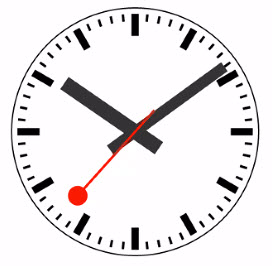

In [1]:
from IPython.display import Image
Image("swissclocktrain.jpg", height=200,width=200)

## 1) The problem

* **Wider context:** Switzerland public transports are known worldwide for their punctuality. I would like to confirm this hypothesis that overall public transport are reliable while simulatenously assesing potential pockets of lower performance (e.g.: providers, stations or mean of transports with frequent and/or important delays)
* **What problem to address:**
    * Primary: predict delays for train connections in swiss transport network
    * Secondary: assess transport network performance and identify regions/providers/lines with more frequent delays *(part of EDA)*

## 2) The data

<a href=#index>Index for (2) The Data and (3) EDA steps</a>

### (a) Clear overview of your data

* **Source:** Data from [opentransport.swiss](https://opentransportdata.swiss/de/organization/oevch)
    * Main data set: actual arrival and departure time of all lines compare to planning [here](https://opentransportdata.swiss/de/dataset/istdaten)
    * Secondary data set: additional informations on stations locations [here](https://opentransportdata.swiss/de/dataset/bav_liste) *(will be joined to main data set on 'stop_id')*
* **Time period:** Focusing on October 2020
* **Initial features:** 21 features in main data set and plan to add 4-5 features from secondary data set as well as from feature engineering. Main features below:
    * Operating_day
    * Operator_name
    * Transport_mode
    * Line_id
    * Stop_name (pick-up, stations, ..)
    * Stop_location
    * arrival_time (DD.MM.YYYY HH24:MI)
    * eta (estimated time of arrival) (DD.MM.YYYY HH24:MI:SS)
    * eta_status ("unkown","empty","estimated","actual")
    * departure_time
    * etd (estimated time of departure)
    * etd_status
* **Samples:** approx. 1.5m rows per day (after EDA will focus on subset of data representing ~200k rows per day)
* **Granularity:** every departures/arrival per stations/transport mode/line/day
* **Quality:** overall good quality from initial analysis but will need to deal with NULL entries and some inaccurate taggings (e.g.: arrival and departure times sometimes missing or "estimated")
* **Data acquisition/collection:** download CSVs in ZIP files from [Google drive](https://drive.google.com/drive/folders/1SVa68nJJRL3qgRSPKcXY7KuPN9MuHVhJ) publicly provided as there is no API available *(Link: <a href=#main_import>unzip</a>)*

### (b) Plan to manage and process the data

* **Managing data:** for EDA using all data for a single day, for ML tasks will be focusing on a subset of the data *("train" transportation only and "Vaud" canton only)* but on several weeks *(2 weeks for training, 1 week for validation, 1 week for testing)*
* **Data cleaning and manipulation:** *(Link: <a href=#main_import>main</a>, <a href=#secondary_set>secondary</a>)*
    * translate features and entries from german to english 
    * removed unnecessary features *(e.g.: features which are duplicats between ID, short names and long names)*
    * update data types
    * deal with NULL entries
    * deal with uncertainty in some flags *(e.g.: estimated_time_arrival_status)*
* **Feature engineering:** *(Link: <a href=#main_feature_eng>main</a>)*
    * add week_day, time_of_day_flag, start_middle_end *(of trip)*, delay_min, delay_bucket *(e.g.: "on time","delay","important delay")*
* **Merging data sets:** augmentating data from main souce with secondary data source features *(additional information on station/stop location)* *(Link: <a href=#merge_sets>merged</a>)*
* **Preprocessing:** encoding of categorical and ordinal variables with one-hot-encoding will be required. Standardization for some of the linear features *(done in 2nd notebook)*

## 3) Exploratory data analysis (EDA)
<a name='eda'/>
<a href=#index>Index for (2) The Data and (3) EDA steps</a>

### (a) Preliminary EDA 

* **EDA done:**
    * Map of all stations in switzerland *(Link: <a href=#secondary_viz>Viz</a>*)
    * Number of stops per cantons *(Link: <a href=#secondary_viz>Viz</a>*)
    * Distribution number of entries per transport mode *(Link: <a href=#explore_target>Viz</a>*)
    * Distribution of pick-ups per day/time of the day *(Link: <a href=#main_feature_eng>Viz</a>*)
    * Distribution of delays per day/time of the day *(Link: <a href=#corr_time_of_day>Viz</a>*)
    * Median delay or share of delay per stations/mean of transport/time of the day *(Link: <a href=#share_delays>Viz</a>*)
    * Outliers detection using z-scores *(Link: <a href=#outliers>Viz</a>*)
    * Delay buckets per transport mode *(Link: <a href=#delay_buckets>Viz</a>*)
    * Cantons and providers with highest shares of delays *(Link: <a href=#share_delays>Viz</a>*)

### (b) How does the EDA inform your project plan?

* **Scope:** 
    * Mean of transport: based on EDA planning I decided to focus project and ML tasks on subset of the data, **"train"** transportation network only, as seems to have higher quality of data *(<a href=#explore_target>% of "real" data</a>)* and volume allowing to include multiple days/weeks *(~200k rows per day)*
    * Region: although EDA will be based on all of Switzerland, ML tasks will be done on only one canton, **Vaud**. Main reason for this is to try improve performance of the classifiers with more data points (e.g.: days) on smaller set instead of lower data points on wider set, while being consicous of computing power of my computer
* **Target:** based on <a href=#explore_target>EDA</a> planning to predict both if there are any delays above 2min and above 5min (building two separate models)
* **ML task:** Decision to work on classification tasks instead of regression as quality granularity of the data is dependent on each providers *(<a href=#delay_buckets>e.g.: seconds vs minutes level of granularity</a>)* and would have strong bias on regression modelling
    * for prediction of both delays (2min+) and important delays (5min+) the classes are <a href=#explore_target>very imbalanced</a>, respectively ~20% and ~5% positive class, thus model evaluation/comparison using accuracy/score wouldn't be relevant. I will be using f1 score, precision, recall and precision-recall curve to optimize classifiers

### (c) What further EDA do you plan for your project?

* **Features relationsip:** 
    * Input features correlation to target *(Link: <a href=#corr_time_of_day>Viz</a>)*
    * Input feature correlation to each others *(Link: <a href=#corr_time_of_day>Viz</a>)*

## 4) Machine learning 

### (a) Phrase your project goal as a clear machine learning question

* **Delay prediction:** Evaluate and compare 5 different supervised ML binary classifiers *(see section below)* to predict train delays arrival in switzerland

### (b) What models are you planning to use and why?

* **Supervised ML classifier:** models choosen based on (1) relevancy for the test and data set, (2) mix of linear and non-linear and (3) diversity of (hyper)parameters tuning possibilities (4) computing power requirements
    * Logistic Regression: tune regularization strength (C) and class_weight with GridSearchCV (gridsearch + cross-validation)
    * SVMs: Linear SVC tuning regularization strength (C) and class_weight using a loop
    * Trees: DecisionTree tuning number max_depth and class_weight using GridSearchCV as well as RandomForest tuning max_depth, number of estimators and class_weight usuing GirdSearchCV
    * Keras network: optimize parameters with a 3 layers model

### (c) Please tell us your detailed machine learning strategy 

* **Binary vs Multiclass:** 
    * Comparing classifiers mentioned above on two binary models *(predicting delays above 2mins and predicting delays above 5mins)*
    * Alsco comparing to one multiclass classifier using RandomForest (e.g.: "no delay","Delay","important delay")*
* **Pre-processing:** one-hot-encoding categorical variables (most variables) and use StandardScaler for linear features
* **Evaluation metrics:**
    * Confusion Matrix and classification report: compare classifiers with imbalanced classes using confusion matrix and classification report metrics like f1 score, recall and precision *(compare models to each others and to baseline)*
    * *Accuracy/Score: not relevant as we have highly imbalanced sets*

## 5) Additional information

* In my initial plans I wanted to work on both supervised and unsupervised models. After careful considerations I decided to go deeper on supervised modelling for imbalanced data set instead of building unsupervised model (i.e.: anomaly detection in EDA). I am happy this decision allowed me to deepen my knoweldge on imbalanced data sets metrics and classifiers performance.
* In my initial plans I also wanted to have a wider scope focusing not only a specific region but for computing power reasons I had to focus on smaller set. I am aware of several aspects I could improve on this project to reach higher peformance/insights and will reflect on them in the "Final comments" section of the 3rd (and last) notebook
* Project is split between 3 notebooks:
    * 1. Project proposal including EDA - "Capstone-proposal-GregoireLAURENT-vFinal"
    * 2. Data cleaning based on EDA and ML tasks - "Capstone-project-GregoireLaurent-Datacleaning"
    * 3. ML tasks - "Capstone-project-GregoireLaurent-MLtasks"
    
## 6) Final comparison and comments

### Final comments (from ML tasks analysis on 3rd Notebook)
- **F1 scores:**
    * Delay: 
        * Two classifiers (k-NN untuned and RandomForest) are under-performing slightly
        * All other clasifiers are reaching almost same f1 score ~0.63 with LogisticRegression reaching the highest score at 0.635
        * From all classifiers performing well, Keras is the one with the best balance between precision (0.55) and recall (0.71)
    * Important delay:
        * Two classifiers (k-NN untuned and DecisionTree) are under-performing slightly
        * All other clasifiers are reaching almost same f1 score ~0.30 with Keras reaching the highest score at 0.313
        * From all classifiers performing well LogisticRegression, RandomForest and Keras have the strongest balance between precision and recall (0.55)
- **Area under Precision-Recall:**
    * Delay:
        * Baseline (0.25) is largely over-performed by all classifiers (0.58 to 0.64)
        * SVC Linear and LogisticRegression achieve the highest AUC with 0.652, Keras is very second with 0.647
    * Important delay: 
        * Baseline (0.06) is largely over-performed by all classifiers (0.22 to 0.29)
        * Keras achieves the highst AUC with 0.288, SVC Linear (0.281) very close


* **Overall comment:** link back to initial question. How often trains are delay at arrival? Is it possible to predict?
    * Classifiers: Keras, LogisticRegression and Linear SVC seem to be over-performing other classifiers on those tasks and getting very close results one to another. DecisionTree and RandomForest have good results on train-validatoin sets but seems to have over-fitting impacting performance on test set. K-NN achieves good performance given the fact is has not been tuned.
    * Optimization: (hyper)parameters (incl. class_weight) tuning and threshold optimization prove to have significant impact on final performance of the models
    * Preditions: Overall performance relatively low with precision and recall between 0.5 and 0.7 seems to indicate there are limited number of patterns to extract from the data to perdict delay. This would indicate that delays are not a systematic issues in some connection, don't happen frequently on same connection and are therefore relatively hard to precit
    

- **Limitations and additional steps:**
    * Limitation - scope: would have needed to use more data points to get to better models. It seems there was very few patterns to identify from 2-3 weeks of data (which probably indicates that delays on swiss trian network is rather rare and not frequent on same lines). Could have limited to even smaller scope but include 2-3 months of data.
    * Limitation - features: additional feature engineering or external data points could have helped enhanced a data set which had alsmot only categorical variables
    * Additional steps: didn't cover over- and under-sampling which would also improve performance
    * Alternative steps: could have thought of aggregating data and buildling model for example at "stop" level instead of each connections. This could have allowed to take into consideration data for a longer time period
    
## Defence notes on discussion with instructors (Mohamad + Arnaud)
    * Could try to deep-dive on incorrect predictions (False negative & False positive) to understand if driven by some specific features or combinations (e.g.: all bad predictions are for city = 'Lausanne', all bad predictions are for weekend days, do we have different distribution for a specific feature between correct and incorrect predictions?)
    * Additional feature engineering could be weekend_flag, nbr_stops_on_line, etc...., weather (external), ...
    * Limitation seems to be driven by quality of features and not Classifiers tuning. To improve models we would need to improve features feeding the model (more features, longer time period, ...)
    * Delay can be looked at from customer or operator perspective (will be train be late? vs. On which rides part do we have more delays issues?)

-----

## (2) The Data + (3) EDA

**INDEX** <a name='index'/>
* <a href=#secondary_set>Secondary data set cleaning</a>:
    * <a href=#secondary_import>import data, renaming columns and initial data overview</a>
    * <a href=#secondary_dtypes>Update data types here</a>
    * <a href=#secondary_nulls>Handle NULL values</a>
    * <a href=#secondary_viz>Vizualisation</a>
* <a href=#main_set>Main data set cleaning</a>:
    * <a href=#main_import>import data, renaming columns and initial data overview</a>
    * <a href=#main_dtypes>Update data types here</a>
    * <a href=#main_nulls>Handle NULL values</a>
    * <a href=#main_feature_eng>Feature Engineering</a>
* <a href=#merge_sets>Merging both data sets</a>
* <a href=#explore_target>Explore Target variable</a>
* <a href=#outliers>Outliers</a>
* <a href=#saving_data>Saving data</a>

In [2]:
import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt

#### Secondary data set: List of stops/stations and their locations in Switzerland: <a name='secondary_import' /> <a name='secondary_set'/>
<a href=#index>Back to top</a>
* Decided to start with discovery and cleaning of secondary data set as will be usefull to handle some Null values in Main data seet

In [3]:
df_stops = pd.read_csv('bav_list_current_timetable.csv',usecols=['Dst-Nr85','Name','Verkehrsmittel','TU-Abk','Gde-Nr','Gemeinde','Kt.','E-Koord.','N-Koord.','Höhe'],skiprows=(1,2,3), low_memory=False)
print('Shape frame:',df_stops.shape)

Shape frame: (28761, 10)


In [4]:
# columns german
df_stops.columns

Index(['Dst-Nr85', 'Name', 'Verkehrsmittel', 'TU-Abk', 'Gde-Nr', 'Gemeinde',
       'Kt.', 'E-Koord.', 'N-Koord.', 'Höhe'],
      dtype='object')

In [5]:
# translate columns from german to english
df_stops.rename(columns={'Dst-Nr85':'stop_id','Name':'stop_name','Verkehrsmittel':'transport_mode','TU-Abk':'provider_short','Gde-Nr':'city_id','Gemeinde':'city','Kt.':'canton','E-Koord.':'longitude_ch','N-Koord.':'latitude_ch','Höhe':'altitude'}, inplace=True)
df_stops.columns

Index(['stop_id', 'stop_name', 'transport_mode', 'provider_short', 'city_id',
       'city', 'canton', 'longitude_ch', 'latitude_ch', 'altitude'],
      dtype='object')

In [6]:
df_stops.head()

,stop_id,stop_name,transport_mode,provider_short,city_id,city,canton,longitude_ch,latitude_ch,altitude
0,8506013,Aadorf,Zug,SBB,4551,Aadorf,TG,2'710'378,1'260'736,528
1,8573363,"Aadorf, Bahnhof",Bus,PAG,4551,Aadorf,TG,2'710'335,1'260'768,528
2,8576958,"Aadorf, Matthofstrasse",Bus,PAG,4551,Aadorf,TG,2'710'483,1'260'407,531
3,8506853,"Aadorf, Morgental",Bus,PAG,4551,Aadorf,TG,2'709'827,1'261'373,517
4,8573362,"Aadorf, Zentrum",Bus,PAG,4551,Aadorf,TG,2'710'079,1'261'060,528


In [7]:
# dimensionality of the features (stop_id and name are unique)
df_stops.nunique()

stop_id           28761
stop_name         28761
transport_mode       30
provider_short      395
city_id            2169
city               2171
canton               26
longitude_ch      26958
latitude_ch       26253
altitude           2152
dtype: int64

**Update data types** *(secondary dataset)* <a name='secondary_dtypes' /> | <a href=#index>Back to top</a>

In [8]:
# original data types
df_stops.dtypes

stop_id            int64
stop_name         object
transport_mode    object
provider_short    object
city_id            int64
city              object
canton            object
longitude_ch      object
latitude_ch       object
altitude          object
dtype: object

In [9]:
df_stops['latitude_ch'] = df_stops['latitude_ch'].str.replace("'","").astype(int)
df_stops['longitude_ch'] = df_stops['longitude_ch'].str.replace("'","").astype(int)
df_stops['altitude'] = df_stops['altitude'].str.replace("'","").astype(int)
df_stops['stop_id'] = df_stops['stop_id'].astype(str)

In [10]:
# updated data types
df_stops.dtypes

stop_id           object
stop_name         object
transport_mode    object
provider_short    object
city_id            int64
city              object
canton            object
longitude_ch       int32
latitude_ch        int32
altitude           int32
dtype: object

**Handle Null values** *(secondary dataset) - as this dataset will be used in a left Join I would rather fill nulls values with a meaningful logic instead of dropping them* <a name='secondary_nulls' /> | <a href=#index>Back to top</a>

In [11]:
df_stops.isnull().sum()

stop_id              0
stop_name            0
transport_mode    1580
provider_short      35
city_id              0
city               817
canton            1023
longitude_ch         0
latitude_ch          0
altitude             0
dtype: int64

* *Transport_mode*

In [12]:
# could have check most frequent 'transport_mode' per 'provider_short' to fillna or more advenced like k-NN, but for now will fillna with 'unbekannt' = 'unknown'
df_stops[df_stops['transport_mode'].isnull()].head(5)

,stop_id,stop_name,transport_mode,provider_short,city_id,city,canton,longitude_ch,latitude_ch,altitude
6,8502170,Aarau AVA,NaN,AVA,4001,Aarau,AG,2646361,1249090,383
7,8502136,Aarau GB,NaN,SBB,4003,Buchs (AG),AG,2647398,1249490,383
8,8502140,Aarau Ost (Abzw),NaN,SBB,4003,Buchs (AG),AG,2647840,1249574,381
75,8502013,Aarburg-Oftringen Süd (Abzw),NaN,SBB,4280,Oftringen,AG,2636164,1240407,414
76,8508141,Aarburg-Oftringen West (Abzw),NaN,SBB,4271,Aarburg,AG,2635405,1240413,409


In [13]:
df_stops['transport_mode'].value_counts(normalize=True).head(10)

Bus              0.848350
Zug              0.065892
Sesselbahn       0.022001
Kabinenbahn      0.018248
Bus_Tram         0.014422
Schiff           0.014275
Tram             0.005040
Standseilbahn    0.004452
Unbekannt        0.002428
Zahnradbahn      0.002171
Name: transport_mode, dtype: float64

In [14]:
df_stops['transport_mode'].fillna(value='Unbekannt', inplace=True)

* *Canton*

In [15]:
# decide to remove entries with 'canton' = Null as those are stops outside of switzerland and want to focus on switzerland only
df_stops[df_stops['canton'].isnull()].head()

,stop_id,stop_name,transport_mode,provider_short,city_id,city,canton,longitude_ch,latitude_ch,altitude
178,8595270,"Adelhausen, Adler",Bus,SBG,0,NaN,NaN,2624270,1273493,452
179,8595269,"Adelhausen, Dinkelberger Hof",Bus,SBG,0,NaN,NaN,2624234,1273669,452
180,8595268,"Adelhausen, Hüsingerstrasse",Bus,SBG,0,NaN,NaN,2624294,1273957,449
412,8518814,Albbruck,Zug,DB,0,NaN,NaN,2652100,1271515,320
472,8518801,Allensbach,Zug,DB,0,NaN,NaN,2722140,1286230,403


In [16]:
df_stops_clean = df_stops[~df_stops['canton'].isnull()]
df_stops_clean.isnull().sum()

stop_id           0
stop_name         0
transport_mode    0
provider_short    1
city_id           0
city              1
canton            0
longitude_ch      0
latitude_ch       0
altitude          0
dtype: int64

* *City*

In [17]:
# only one 'city' = Null. Manualy search to fill with correct city. Also realize city_id is missing and doing same exercise to correct data
df_stops_clean[df_stops_clean['city'].isnull()]

,stop_id,stop_name,transport_mode,provider_short,city_id,city,canton,longitude_ch,latitude_ch,altitude
3269,8582183,"Bonfol, gare",Bus,CJ,0,NaN,JU,2578596,1258242,437


In [18]:
df_stops_clean[df_stops_clean['stop_name'].str.contains('Bonfo')]

,stop_id,stop_name,transport_mode,provider_short,city_id,city,canton,longitude_ch,latitude_ch,altitude
3268,8500188,Bonfol,Zug,CJ,6775,Bonfol,JU,2578611,1258223,437
3269,8582183,"Bonfol, gare",Bus,CJ,0,NaN,JU,2578596,1258242,437


In [19]:
df_stops_clean['city'].fillna(value='Bonfol',inplace=True)

C:\Users\glaurent\AppData\Local\Continuum\anaconda3\envs\exts-ml\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [20]:
df_stops_clean[df_stops_clean['city'].str.contains('Bonfo')]

,stop_id,stop_name,transport_mode,provider_short,city_id,city,canton,longitude_ch,latitude_ch,altitude
3268,8500188,Bonfol,Zug,CJ,6775,Bonfol,JU,2578611,1258223,437
3269,8582183,"Bonfol, gare",Bus,CJ,0,Bonfol,JU,2578596,1258242,437


In [21]:
df_stops_clean[df_stops_clean['city_id'] == 0]

,stop_id,stop_name,transport_mode,provider_short,city_id,city,canton,longitude_ch,latitude_ch,altitude
3269,8582183,"Bonfol, gare",Bus,CJ,0,Bonfol,JU,2578596,1258242,437


In [22]:
df_stops_clean['city_id'].replace(to_replace=0, value=6775, inplace=True)

C:\Users\glaurent\AppData\Local\Continuum\anaconda3\envs\exts-ml\lib\site-packages\pandas\core\generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [23]:
df_stops_clean.isnull().sum()

stop_id           0
stop_name         0
transport_mode    0
provider_short    1
city_id           0
city              0
canton            0
longitude_ch      0
latitude_ch       0
altitude          0
dtype: int64

* *provider_short*

In [24]:
# Only one NUll for 'provider_short'. Even if it seems this city is mostly covered by Bus connections I prefer to keep it as 'Unbekannt' for now
df_stops_clean[df_stops_clean['provider_short'].isnull()]

,stop_id,stop_name,transport_mode,provider_short,city_id,city,canton,longitude_ch,latitude_ch,altitude
3423,8587729,"Boveresse, temple TRN/Autorvt",Unbekannt,NaN,6512,Val-de-Travers,NE,2536098,1196463,735


In [25]:
df_stops_clean[df_stops_clean['city_id'] == 6512]['transport_mode'].value_counts()

Bus           41
Zug            8
Unbekannt      5
Sesselbahn     2
Name: transport_mode, dtype: int64

In [26]:
df_stops_clean['provider_short'].value_counts(normalize=True).head()

PAG    0.364423
SBB    0.054945
TPF    0.029131
TPG    0.027292
VBZ    0.026319
Name: provider_short, dtype: float64

In [27]:
df_stops_clean['provider_short'].fillna(value='Unbekannt', inplace=True) # fill with 'unkown'

In [28]:
print(df_stops_clean.isnull().sum().sum(),' Nulls remaining in secondary dataset')

0  Nulls remaining in secondary dataset


**Data Vizualisation** *(secondary dataset)* | <a href=#index>Back to top</a> | <a href=#eda>Back to EDA</a>
<a name='secondary_viz'/>

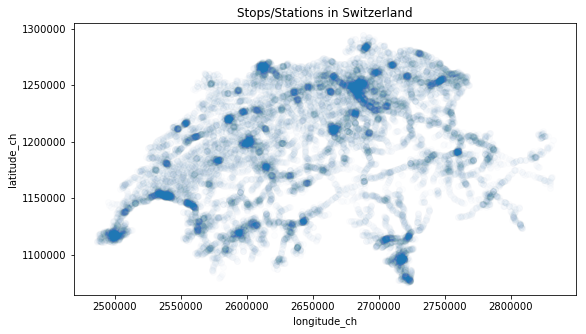

In [29]:
plt.figure(figsize=(9,5))
plt.scatter(x='longitude_ch',y='latitude_ch',data=df_stops_clean, alpha=0.01)
#plt.scatter(x='longitude_ch',y='latitude_ch',data=df_stops[df_stops['canton'].isnull()], alpha=0.2)
plt.xlabel('longitude_ch')
plt.ylabel('latitude_ch')
plt.title('Stops/Stations in Switzerland')
plt.show()

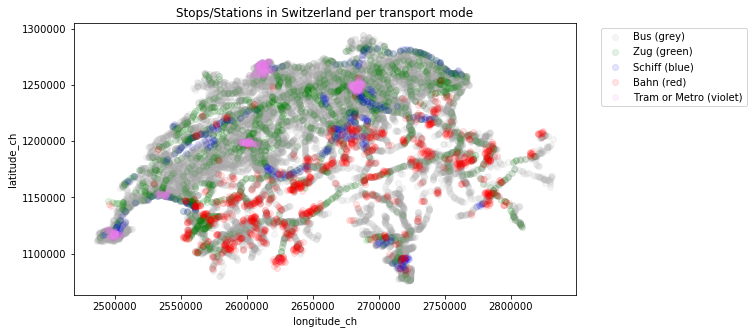

In [30]:
plt.figure(figsize=(9,5))
plt.scatter(x='longitude_ch',y='latitude_ch',data=df_stops_clean[df_stops_clean['transport_mode'].str.contains('Bus')], alpha=0.1, label='Bus (grey)',c='darkgrey')
plt.scatter(x='longitude_ch',y='latitude_ch',data=df_stops_clean[df_stops_clean['transport_mode'].str.contains('Zug')], alpha=0.1, label='Zug (green)', c='green')
plt.scatter(x='longitude_ch',y='latitude_ch',data=df_stops_clean[df_stops_clean['transport_mode'].str.contains('Schiff')], alpha=0.1, label='Schiff (blue)', c='blue')
plt.scatter(x='longitude_ch',y='latitude_ch',data=df_stops_clean[df_stops_clean['transport_mode'].str.contains('bahn')], alpha=0.1, label='Bahn (red)', c='red')
plt.scatter(x='longitude_ch',y='latitude_ch',data=df_stops_clean[df_stops_clean['transport_mode'].str.contains('Tram|Metro')], alpha=0.1, label='Tram or Metro (violet)', c='violet')
#plt.scatter(x='longitude_ch',y='latitude_ch',data=df_stops[df_stops['canton'].isnull()], alpha=0.2)
plt.xlabel('longitude_ch')
plt.ylabel('latitude_ch')
plt.title('Stops/Stations in Switzerland per transport mode')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

In [31]:
print('Top 10 Transport mode distribution (%) => Bus and Train represent almost 90% of stops')
round(df_stops_clean['transport_mode'].value_counts(normalize=True).head(10)*100,1)

Top 10 Transport mode distribution (%) => Bus and Train represent almost 90% of stops


Bus              80.2
Zug               6.2
Unbekannt         5.7
Sesselbahn        2.1
Kabinenbahn       1.8
Bus_Tram          1.4
Schiff            1.2
Tram              0.5
Standseilbahn     0.4
Zahnradbahn       0.2
Name: transport_mode, dtype: float64

In [32]:
print('Top 10 Providers distribution (%) => except for PAG (PostAuto AG - mostly buses) there is a long tail in the distribution')
round(df_stops_clean['provider_short'].value_counts(normalize=True).head(10)*100,1)

Top 10 Providers distribution (%) => except for PAG (PostAuto AG - mostly buses) there is a long tail in the distribution


PAG    36.4
SBB     5.5
TPF     2.9
TPG     2.7
VBZ     2.6
TL      1.9
BOS     1.7
VZO     1.7
TRN     1.4
ZVB     1.4
Name: provider_short, dtype: float64

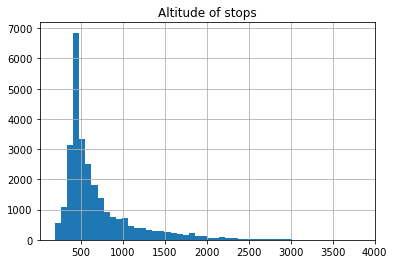

In [33]:
df_stops_clean['altitude'].hist(bins=50)
plt.title('Altitude of stops')
plt.show()

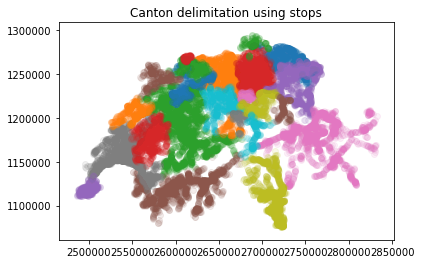

In [34]:
cantons = df_stops_clean['canton'].unique()
for c in cantons:
    plt.scatter(x='longitude_ch', y='latitude_ch', data=df_stops_clean[df_stops_clean['canton'] == c], alpha=0.1)
plt.title('Canton delimitation using stops')
plt.show()

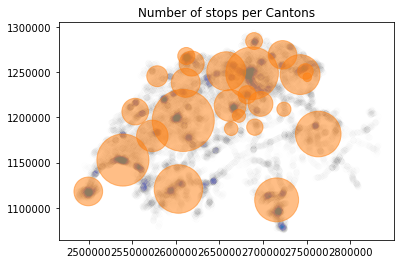

In [35]:
df_stops_canton = df_stops_clean.groupby('canton').agg({'longitude_ch':'median','latitude_ch':'median','stop_id':'count'})
plt.scatter(x='longitude_ch',y='latitude_ch',data=df_stops_clean, alpha=0.005)
plt.scatter(x='longitude_ch', y='latitude_ch', s='stop_id',data=df_stops_canton, alpha=0.5)
plt.title('Number of stops per Cantons')
plt.show()

#### Main data set: "Actual data" <a name='main_set'/> <a name='main_import'/> 
<a href=#index>Back to top</a>

In [36]:
zf = zipfile.ZipFile('20_10.zip') 
df = pd.read_csv(zf.open('20_10/2020-10-01_istdaten.csv'),delimiter=';',low_memory=False) # import data for single day (1st October) for 

In [37]:
# shape of data frame for single day of data
print('Shape frame:',df.shape)

Shape frame: (1854124, 21)


In [38]:
df.columns

Index(['BETRIEBSTAG', 'FAHRT_BEZEICHNER', 'BETREIBER_ID', 'BETREIBER_ABK',
       'BETREIBER_NAME', 'PRODUKT_ID', 'LINIEN_ID', 'LINIEN_TEXT', 'UMLAUF_ID',
       'VERKEHRSMITTEL_TEXT', 'ZUSATZFAHRT_TF', 'FAELLT_AUS_TF', 'BPUIC',
       'HALTESTELLEN_NAME', 'ANKUNFTSZEIT', 'AN_PROGNOSE',
       'AN_PROGNOSE_STATUS', 'ABFAHRTSZEIT', 'AB_PROGNOSE',
       'AB_PROGNOSE_STATUS', 'DURCHFAHRT_TF'],
      dtype='object')

In [39]:
# translating columns naming from german to english
df.rename(columns={'BETRIEBSTAG':'operating_day','FAHRT_BEZEICHNER':'ride_id','BETREIBER_ID':'operator_id','BETREIBER_ABK':'operator_short','BETREIBER_NAME':'operator_name',\
                   'PRODUKT_ID':'transport_mode','LINIEN_ID':'line_id','LINIEN_TEXT':'line_name','UMLAUF_ID':'deviation_id','VERKEHRSMITTEL_TEXT':'product_id','ZUSATZFAHRT_TF':'add_ride_flag',\
                  'FAELLT_AUS_TF':'missing_ride_flag','BPUIC':'stop_id','HALTESTELLEN_NAME':'stop_name','ANKUNFTSZEIT':'arrival_time','AN_PROGNOSE':'eta','AN_PROGNOSE_STATUS':'eta_status'\
                   ,'ABFAHRTSZEIT':'departure_time','AB_PROGNOSE':'etd','AB_PROGNOSE_STATUS':'etd_status','DURCHFAHRT_TF':'ride_through_flag'}, inplace=True)
df.columns

Index(['operating_day', 'ride_id', 'operator_id', 'operator_short',
       'operator_name', 'transport_mode', 'line_id', 'line_name',
       'deviation_id', 'product_id', 'add_ride_flag', 'missing_ride_flag',
       'stop_id', 'stop_name', 'arrival_time', 'eta', 'eta_status',
       'departure_time', 'etd', 'etd_status', 'ride_through_flag'],
      dtype='object')

In [40]:
# overview of data
df.head().T

,0,1,2,3,4
operating_day,01.10.2020,01.10.2020,01.10.2020,01.10.2020,01.10.2020
ride_id,80:06____:17001:000,80:06____:17003:000,80:06____:17005:000,80:06____:17006:000,80:06____:17007:000
operator_id,80:06____,80:06____,80:06____,80:06____,80:06____
operator_short,DB,DB,DB,DB,DB
operator_name,DB Regio AG Baden-Württemberg,DB Regio AG Baden-Württemberg,DB Regio AG Baden-Württemberg,DB Regio AG Baden-Württemberg,DB Regio AG Baden-Württemberg
transport_mode,Zug,Zug,Zug,Zug,Zug
line_id,17001,17003,17005,17006,17007
line_name,RE,RE,RE,RE,RE
deviation_id,NaN,NaN,NaN,NaN,NaN
product_id,RE,RE,RE,RE,RE


In [41]:
# dimensionality of each features
df.nunique()

operating_day             1
ride_id              112606
operator_id             124
operator_short          121
operator_name           122
transport_mode            7
line_id               13439
line_name               646
deviation_id           2549
product_id               25
add_ride_flag             2
missing_ride_flag         2
stop_id               14429
stop_name             13747
arrival_time           1416
eta                   74425
eta_status                4
departure_time         1417
etd                   74366
etd_status                4
ride_through_flag         2
dtype: int64

In [42]:
print('Transport modes:',df['transport_mode'].unique())
print('ETA status:', df['eta_status'].unique())
print('ETD status:', df['etd_status'].unique())

Transport modes: ['Zug' 'Zahnradbahn' nan 'Bus' 'Metro' 'Schiff' 'Tram' 'BUS']
ETA status: ['PROGNOSE' 'UNBEKANNT' 'REAL' 'GESCHAETZT']
ETD status: ['PROGNOSE' 'UNBEKANNT' 'REAL' 'GESCHAETZT']


In [43]:
# regrouping and renaming of entries
df['transport_mode'].replace({'BUS':'Bus','Zahnradbahn':'Bahn'}, inplace=True)

**Updating data types** <a name='main_dtypes'/> | <a href=#index>Back to top</a>

In [44]:
df.dtypes

operating_day        object
ride_id              object
operator_id          object
operator_short       object
operator_name        object
transport_mode       object
line_id              object
line_name            object
deviation_id         object
product_id           object
add_ride_flag          bool
missing_ride_flag      bool
stop_id               int64
stop_name            object
arrival_time         object
eta                  object
eta_status           object
departure_time       object
etd                  object
etd_status           object
ride_through_flag      bool
dtype: object

In [45]:
# datetime
import datetime
df['operating_day'] = pd.to_datetime(df['operating_day'], format="%d.%m.%Y")
df['arrival_time'] = pd.to_datetime(df['arrival_time'], format="%d.%m.%Y %H:%M")
df['departure_time'] = pd.to_datetime(df['departure_time'], format="%d.%m.%Y %H:%M")
df['eta'] = pd.to_datetime(df['eta'], format="%d.%m.%Y %H:%M:%S")
df['etd'] = pd.to_datetime(df['etd'], format="%d.%m.%Y %H:%M:%S")
# integer to string
df['stop_id'] = df['stop_id'].astype(str)

**Handle Null values** <a name='main_nulls'/> | <a href=#index>Back to top</a>

In [46]:
# Nulls in "deviation_id" is the only exepcted NUlls. Would need to decide how to deal with other "Null" values
df.isnull().sum()

operating_day             0
ride_id                   0
operator_id               0
operator_short            0
operator_name             0
transport_mode          669
line_id                   0
line_name                 0
deviation_id         796253
product_id            63743
add_ride_flag             0
missing_ride_flag         0
stop_id                   0
stop_name             55027
arrival_time         111780
eta                  135823
eta_status                0
departure_time       110216
etd                  134275
etd_status                0
ride_through_flag         0
dtype: int64

* *Transport Mode*

In [47]:
df[df['transport_mode'].isnull()].nunique()

operating_day          1
ride_id               51
operator_id            2
operator_short         2
operator_name          2
transport_mode         0
line_id               25
line_name             19
deviation_id           0
product_id             5
add_ride_flag          2
missing_ride_flag      2
stop_id              176
stop_name            176
arrival_time         394
eta                  563
eta_status             2
departure_time       400
etd                  568
etd_status             2
ride_through_flag      1
dtype: int64

In [48]:
df[df['transport_mode'].isnull()]['operator_short'].value_counts()
# looking in more details at those providers it seems we would be able to assume 'transport_mode' based on other similar data points

TL     531
SBB    138
Name: operator_short, dtype: int64

In [49]:
df[df['operator_short'] == 'SBB']['transport_mode'].value_counts()

Zug    63469
Name: transport_mode, dtype: int64

In [50]:
df[df['operator_short'] == 'TL']['transport_mode'].value_counts()

Bus      104910
Metro      5101
Name: transport_mode, dtype: int64

In [51]:
# grouping 'operators','lines' to be able to assume 'transport_mode' for missing entries
df_trans_mode = df.groupby(['operator_short','line_name','transport_mode'])[['ride_id']].count().reset_index()\
.pivot_table(index=['operator_short','line_name'], columns='transport_mode', values='ride_id').fillna(0).reset_index()
df_trans_mode['total'] = df_trans_mode['Bahn'] + df_trans_mode['Bus'] + df_trans_mode['Metro'] + df_trans_mode['Schiff'] + df_trans_mode['Tram'] + df_trans_mode['Zug']
df_trans_mode.head()

transport_mode,operator_short,line_name,Bahn,Bus,Metro,Schiff,Tram,Zug,total
0,AAGL,70,0.0,1973.0,0.0,0.0,0.0,0.0,1973.0
1,AAGL,71,0.0,842.0,0.0,0.0,0.0,0.0,842.0
2,AAGL,72,0.0,1014.0,0.0,0.0,0.0,0.0,1014.0
3,AAGL,75,0.0,586.0,0.0,0.0,0.0,0.0,586.0
4,AAGL,76,0.0,657.0,0.0,0.0,0.0,0.0,657.0


In [52]:
threshold = 0.95
def label_trans_mode (row):
    if row['Bahn']/row['total'] > threshold:
        return 'Bahn'
    if row['Bus']/row['total'] > threshold:
        return 'Bus'
    if row['Metro']/row['total'] > threshold:
        return 'Metro'
    if row['Schiff']/row['total'] > threshold:
        return 'Schiff'
    if row['Tram']/row['total'] > threshold:
        return 'Tram'
    if row['Zug']/row['total'] > threshold:
        return 'Zug'
    return 'unknown'

In [53]:
df_trans_mode['trans_mode_est'] = df_trans_mode.apply(lambda row: label_trans_mode(row), axis=1)
df_trans_mode[df_trans_mode['operator_short'] == 'TL'].tail()

transport_mode,operator_short,line_name,Bahn,Bus,Metro,Schiff,Tram,Zug,total,trans_mode_est
853,TL,69,0.0,320.0,0.0,0.0,0.0,0.0,320.0,Bus
854,TL,7,0.0,3265.0,0.0,0.0,0.0,0.0,3265.0,Bus
855,TL,8,0.0,7122.0,0.0,0.0,0.0,0.0,7122.0,Bus
856,TL,9,0.0,7175.0,0.0,0.0,0.0,0.0,7175.0,Bus
857,TL,m1,0.0,0.0,5101.0,0.0,0.0,0.0,5101.0,Metro


In [54]:
df_trans_mode[df_trans_mode['trans_mode_est'] == 'unknown']

transport_mode,operator_short,line_name,Bahn,Bus,Metro,Schiff,Tram,Zug,total,trans_mode_est
248,BVB,3,0.0,2484.0,0.0,0.0,5847.0,0.0,8331.0,unknown


In [55]:
df_clean = pd.merge(left=df, right=df_trans_mode[['operator_short','line_name','trans_mode_est']], how='left', on=['operator_short','line_name'])
df_clean['transport_mode'] = df_clean['transport_mode'].fillna(df_clean['trans_mode_est'])

In [56]:
df_clean['transport_mode'].isnull().sum()

0

* *Stop name*

In [57]:
df_clean[df_clean['stop_name'].isnull()].nunique()
# shall be able to reconcile by joining to secondary data set

operating_day            1
ride_id               3006
operator_id              4
operator_short           4
operator_name            4
transport_mode           1
line_id                 51
line_name               50
deviation_id            85
product_id               1
add_ride_flag            2
missing_ride_flag        2
stop_id                709
stop_name                0
arrival_time          1254
eta                  32478
eta_status               3
departure_time        1253
etd                  33658
etd_status               3
ride_through_flag        1
trans_mode_est           1
dtype: int64

In [58]:
df_clean = df_clean.merge(right=df_stops_clean[['stop_name','stop_id']], how='left', on=['stop_id'], suffixes=('','_bis'))

In [59]:
df_clean['stop_name'].fillna(df_clean['stop_name_bis'], inplace=True)

In [60]:
print('Even after mapping, we still have {} empty "stop_name"'.format(df_clean['stop_name'].isnull().sum()))

Even after mapping, we still have 566 empty "stop_name"


In [61]:
df_clean[df_clean['stop_name'].isnull()].head().T

,1767268,1767286,1767305,1767323,1767363
operating_day,2020-10-01 00:00:00,2020-10-01 00:00:00,2020-10-01 00:00:00,2020-10-01 00:00:00,2020-10-01 00:00:00
ride_id,85:889:1001-1,85:889:1001-1,85:889:1003-1,85:889:1003-1,85:889:1005-1
operator_id,85:889,85:889,85:889,85:889,85:889
operator_short,VB,VB,VB,VB,VB
operator_name,Verkehrsbetriebe der Stadt Biel,Verkehrsbetriebe der Stadt Biel,Verkehrsbetriebe der Stadt Biel,Verkehrsbetriebe der Stadt Biel,Verkehrsbetriebe der Stadt Biel
transport_mode,Bus,Bus,Bus,Bus,Bus
line_id,85:889:1,85:889:1,85:889:1,85:889:1,85:889:1
line_name,1,1,1,1,1
deviation_id,NaN,NaN,NaN,NaN,NaN
product_id,B,B,B,B,B


In [62]:
df_clean['stop_name'].fillna('unknown', inplace=True)

In [63]:
df_clean.isnull().sum()

operating_day             0
ride_id                   0
operator_id               0
operator_short            0
operator_name             0
transport_mode            0
line_id                   0
line_name                 0
deviation_id         796253
product_id            63743
add_ride_flag             0
missing_ride_flag         0
stop_id                   0
stop_name                 0
arrival_time         111780
eta                  135823
eta_status                0
departure_time       110216
etd                  134275
etd_status                0
ride_through_flag         0
trans_mode_est            0
stop_name_bis         27059
dtype: int64

* *Product_id*

In [64]:
df_clean[df_clean['product_id'].isnull()]['operator_short'].value_counts()

RBS Auto    17093
BSU         15516
BLAG        14875
BGU          9117
RBL          6024
VBH           587
TL            531
Name: operator_short, dtype: int64

In [65]:
print('RBS Auto', df_clean[df_clean['operator_short'] == 'RBS Auto']['product_id'].value_counts())
print('BSU',  df_clean[df_clean['operator_short'] == 'BSU']['product_id'].value_counts())
print('TL')
print(df_clean[df_clean['operator_short'] == 'TL']['product_id'].value_counts())

RBS Auto Series([], Name: product_id, dtype: int64)
BSU Series([], Name: product_id, dtype: int64)
TL
B    104910
M      5101
Name: product_id, dtype: int64


In [66]:
df_clean['product_id'].fillna(value='unkown', inplace=True)

* *arrival/departure time*

In [67]:
df_clean.isnull().sum()

operating_day             0
ride_id                   0
operator_id               0
operator_short            0
operator_name             0
transport_mode            0
line_id                   0
line_name                 0
deviation_id         796253
product_id                0
add_ride_flag             0
missing_ride_flag         0
stop_id                   0
stop_name                 0
arrival_time         111780
eta                  135823
eta_status                0
departure_time       110216
etd                  134275
etd_status                0
ride_through_flag         0
trans_mode_est            0
stop_name_bis         27059
dtype: int64

In [68]:
df_clean[df_clean['departure_time'].isnull()].head()
# arrival time and eta can be blank when train is starting from there 'starting trip'
# departure time and etd can be blank when train is ending trip 'ending trip'

,operating_day,ride_id,operator_id,operator_short,operator_name,transport_mode,line_id,line_name,deviation_id,product_id,...,stop_name,arrival_time,eta,eta_status,departure_time,etd,etd_status,ride_through_flag,trans_mode_est,stop_name_bis
0,2020-10-01,80:06____:17001:000,80:06____,DB,DB Regio AG Baden-Württemberg,Zug,17001,RE,NaN,RE,...,Basel Bad Bf,2020-10-01 06:29:00,2020-10-01 06:30:00,PROGNOSE,NaT,NaT,PROGNOSE,False,Zug,Basel Bad Bf
1,2020-10-01,80:06____:17003:000,80:06____,DB,DB Regio AG Baden-Württemberg,Zug,17003,RE,NaN,RE,...,Basel Bad Bf,2020-10-01 08:03:00,2020-10-01 08:03:00,PROGNOSE,NaT,NaT,PROGNOSE,False,Zug,Basel Bad Bf
2,2020-10-01,80:06____:17005:000,80:06____,DB,DB Regio AG Baden-Württemberg,Zug,17005,RE,NaN,RE,...,Basel Bad Bf,2020-10-01 09:29:00,2020-10-01 09:30:00,PROGNOSE,NaT,NaT,PROGNOSE,False,Zug,Basel Bad Bf
4,2020-10-01,80:06____:17007:000,80:06____,DB,DB Regio AG Baden-Württemberg,Zug,17007,RE,NaN,RE,...,Basel Bad Bf,2020-10-01 10:02:00,2020-10-01 10:05:00,PROGNOSE,NaT,NaT,PROGNOSE,False,Zug,Basel Bad Bf
6,2020-10-01,80:06____:17009:000,80:06____,DB,DB Regio AG Baden-Württemberg,Zug,17009,RE,NaN,RE,...,Basel Bad Bf,2020-10-01 11:30:00,2020-10-01 11:38:00,PROGNOSE,NaT,NaT,PROGNOSE,False,Zug,Basel Bad Bf


In [69]:
def start_end(row):
    if row['arrival_time'] is pd.NaT:
        return 'start_trip'
    if row['departure_time'] is pd.NaT:
        return 'end_trip'
    return 'middle_stop'

In [70]:
df_clean['start_middle_end'] = df_clean.apply(lambda row: start_end(row), axis=1)

In [71]:
df_clean.head()

,operating_day,ride_id,operator_id,operator_short,operator_name,transport_mode,line_id,line_name,deviation_id,product_id,...,arrival_time,eta,eta_status,departure_time,etd,etd_status,ride_through_flag,trans_mode_est,stop_name_bis,start_middle_end
0,2020-10-01,80:06____:17001:000,80:06____,DB,DB Regio AG Baden-Württemberg,Zug,17001,RE,NaN,RE,...,2020-10-01 06:29:00,2020-10-01 06:30:00,PROGNOSE,NaT,NaT,PROGNOSE,False,Zug,Basel Bad Bf,end_trip
1,2020-10-01,80:06____:17003:000,80:06____,DB,DB Regio AG Baden-Württemberg,Zug,17003,RE,NaN,RE,...,2020-10-01 08:03:00,2020-10-01 08:03:00,PROGNOSE,NaT,NaT,PROGNOSE,False,Zug,Basel Bad Bf,end_trip
2,2020-10-01,80:06____:17005:000,80:06____,DB,DB Regio AG Baden-Württemberg,Zug,17005,RE,NaN,RE,...,2020-10-01 09:29:00,2020-10-01 09:30:00,PROGNOSE,NaT,NaT,PROGNOSE,False,Zug,Basel Bad Bf,end_trip
3,2020-10-01,80:06____:17006:000,80:06____,DB,DB Regio AG Baden-Württemberg,Zug,17006,RE,NaN,RE,...,NaT,NaT,PROGNOSE,2020-10-01 06:11:00,NaT,UNBEKANNT,False,Zug,Basel Bad Bf,start_trip
4,2020-10-01,80:06____:17007:000,80:06____,DB,DB Regio AG Baden-Württemberg,Zug,17007,RE,NaN,RE,...,2020-10-01 10:02:00,2020-10-01 10:05:00,PROGNOSE,NaT,NaT,PROGNOSE,False,Zug,Basel Bad Bf,end_trip


* *ETA/ETD*

In [72]:
df_clean[~(df_clean['arrival_time'].isnull()) & (df_clean['eta'].isnull())].head(5)

,operating_day,ride_id,operator_id,operator_short,operator_name,transport_mode,line_id,line_name,deviation_id,product_id,...,arrival_time,eta,eta_status,departure_time,etd,etd_status,ride_through_flag,trans_mode_est,stop_name_bis,start_middle_end
85,2020-10-01,80:06____:17260:000,80:06____,DB,DB Regio AG Baden-Württemberg,Zug,17260,RB,NaN,RB,...,2020-10-01 14:07:00,NaT,PROGNOSE,NaT,NaT,PROGNOSE,False,Zug,Basel Bad Bf,end_trip
106,2020-10-01,80:06____:17282:000,80:06____,DB,DB Regio AG Baden-Württemberg,Zug,17282,RB,NaN,RB,...,2020-10-01 19:07:00,NaT,UNBEKANNT,NaT,NaT,PROGNOSE,False,Zug,Basel Bad Bf,end_trip
112,2020-10-01,80:06____:17288:000,80:06____,DB,DB Regio AG Baden-Württemberg,Zug,17288,RB,NaN,RB,...,2020-10-01 22:07:00,NaT,UNBEKANNT,NaT,NaT,PROGNOSE,False,Zug,Basel Bad Bf,end_trip
113,2020-10-01,80:1080:451:000,80:1080,DB,Deutsche Bundesbahn,Zug,451,EC,NaN,EC,...,2020-10-01 10:45:00,NaT,UNBEKANNT,NaT,NaT,PROGNOSE,False,Zug,Basel Bad Bf,end_trip
119,2020-10-01,80:800693:3042:000,80:800693,DB Regio,DB ZugBus Regionalverkehr Alb-Bodensee,Zug,3042,IRE,NaN,IRE,...,2020-10-01 11:16:00,NaT,UNBEKANNT,NaT,NaT,PROGNOSE,False,Zug,Basel Bad Bf,end_trip


In [73]:
df_clean[df_clean['arrival_time'].isnull()]['eta_status'].value_counts()

PROGNOSE    111780
Name: eta_status, dtype: int64

In [74]:
def start_status(row):
    if row['arrival_time'] is pd.NaT:
        return 'NA'
    if row['eta'] is pd.NaT:
        return 'UNKOWN'
    return row['eta_status']

In [75]:
df_clean['eta_status_clean'] = df_clean.apply(lambda row: start_status(row), axis=1)

In [76]:
def end_status(row):
    if row['departure_time'] is pd.NaT:
        return 'NA'
    if row['etd'] is pd.NaT:
        return 'UNKOWN'
    return row['etd_status']

In [77]:
df_clean['etd_status_clean'] = df_clean.apply(lambda row: end_status(row), axis=1)

In [78]:
df_clean.head()

,operating_day,ride_id,operator_id,operator_short,operator_name,transport_mode,line_id,line_name,deviation_id,product_id,...,eta_status,departure_time,etd,etd_status,ride_through_flag,trans_mode_est,stop_name_bis,start_middle_end,eta_status_clean,etd_status_clean
0,2020-10-01,80:06____:17001:000,80:06____,DB,DB Regio AG Baden-Württemberg,Zug,17001,RE,NaN,RE,...,PROGNOSE,NaT,NaT,PROGNOSE,False,Zug,Basel Bad Bf,end_trip,PROGNOSE,NA
1,2020-10-01,80:06____:17003:000,80:06____,DB,DB Regio AG Baden-Württemberg,Zug,17003,RE,NaN,RE,...,PROGNOSE,NaT,NaT,PROGNOSE,False,Zug,Basel Bad Bf,end_trip,PROGNOSE,NA
2,2020-10-01,80:06____:17005:000,80:06____,DB,DB Regio AG Baden-Württemberg,Zug,17005,RE,NaN,RE,...,PROGNOSE,NaT,NaT,PROGNOSE,False,Zug,Basel Bad Bf,end_trip,PROGNOSE,NA
3,2020-10-01,80:06____:17006:000,80:06____,DB,DB Regio AG Baden-Württemberg,Zug,17006,RE,NaN,RE,...,PROGNOSE,2020-10-01 06:11:00,NaT,UNBEKANNT,False,Zug,Basel Bad Bf,start_trip,NA,UNKOWN
4,2020-10-01,80:06____:17007:000,80:06____,DB,DB Regio AG Baden-Württemberg,Zug,17007,RE,NaN,RE,...,PROGNOSE,NaT,NaT,PROGNOSE,False,Zug,Basel Bad Bf,end_trip,PROGNOSE,NA


In [79]:
# arrival - eta
df_clean[df_clean['eta'].isnull()]['eta_status_clean'].value_counts()

NA        111780
UNKOWN     24043
Name: eta_status_clean, dtype: int64

In [80]:
df_clean['eta_status_clean'].value_counts()

PROGNOSE      1174970
REAL           485479
NA             111780
GESCHAETZT      57705
UNKOWN          24043
UNBEKANNT         147
Name: eta_status_clean, dtype: int64

In [81]:
df_clean['eta_status_clean'].replace({'GESCHAETZT':'ESTIMATED','UNBEKANNT':'ESTIMATED'}, inplace=True)

In [82]:
# departure - etd
df_clean[df_clean['etd'].isnull()]['etd_status_clean'].value_counts()

NA        110215
UNKOWN     24060
Name: etd_status_clean, dtype: int64

In [83]:
df_clean['etd_status_clean'].value_counts()

PROGNOSE      1168766
REAL           486304
NA             110216
GESCHAETZT      64629
UNKOWN          24060
UNBEKANNT         149
Name: etd_status_clean, dtype: int64

In [84]:
df_clean['etd_status_clean'].replace({'GESCHAETZT':'ESTIMATED','UNBEKANNT':'ESTIMATED'}, inplace=True)

**Feature engineering**: time_of_day, day_of_week, delay (min), delay (buckets) <a name='main_feature_eng'/> | <a href=#index>Back to top</a> | <a href=#eda>Back to EDA</a>
* time_of_day

C:\Users\glaurent\AppData\Local\Continuum\anaconda3\envs\exts-ml\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


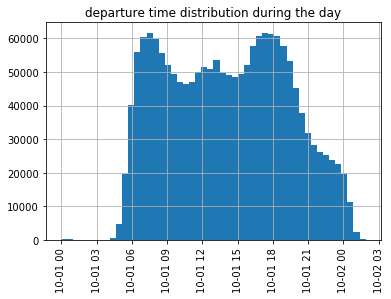

In [85]:
df_clean['departure_time'].hist(bins=50)
plt.title('departure time distribution during the day')
plt.xticks(rotation=90)
plt.show()

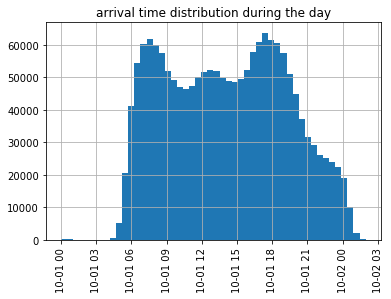

In [86]:
df_clean['arrival_time'].hist(bins=50)
plt.title('arrival time distribution during the day')
plt.xticks(rotation=90)
plt.show()

In [87]:
# create new feature bucketing arrival/departure per hours
df_clean['departure_time_hour'] = df_clean['departure_time'].dt.hour
df_clean['arrival_time_hour'] = df_clean['arrival_time'].dt.hour
#df_clean['departure_day_of_week'] = df_clean['departure_time'].dt.day_name()
#df_clean['arrival_day_of_week'] = df_clean['arrival_time'].dt.day_name()
df_clean['operating_day_of_week'] = df_clean['operating_day'].dt.day_name()

In [88]:
def rush_hour_dep(row):
    if row['departure_time'] is pd.NaT:
        return 'na'
    if row['departure_time_hour'] < 6:
        return 'early_morning'
    if row['departure_time_hour'] < 9:
        return 'peak_morning'
    if row['departure_time_hour'] < 12:
        return 'morning'
    if row['departure_time_hour'] < 14:
        return 'midday'
    if row['departure_time_hour'] < 16:
        return 'afternoon'
    if row['departure_time_hour'] < 20:
        return 'peak_afternoon'
    if row['departure_time_hour'] <= 24:
        return 'evening'
    return 'na'

In [89]:
df_clean['departure_time_of_day'] = df_clean.apply(lambda row: rush_hour_dep(row), axis=1)

In [90]:
def rush_hour_arr(row):
    if row['arrival_time'] is pd.NaT:
        return 'na'
    if row['arrival_time_hour'] < 6:
        return 'early_morning'
    if row['arrival_time_hour'] < 9:
        return 'peak_morning'
    if row['arrival_time_hour'] < 12:
        return 'morning'
    if row['arrival_time_hour'] < 14:
        return 'midday'
    if row['arrival_time_hour'] < 16:
        return 'afternoon'
    if row['arrival_time_hour'] < 20:
        return 'peak_afternoon'
    if row['arrival_time_hour'] <= 24:
        return 'evening'
    return 'na'

In [91]:
df_clean['arrival_time_of_day'] = df_clean.apply(lambda row: rush_hour_arr(row), axis=1)

* delay (min) <a name='delay_buckets'/>
<br><a href=#index>Back to top</a> | <a href=#eda>Back to EDA</a>

In [92]:
df_clean['arrival_delay_min'] = round(((df_clean['eta'] - df_clean['arrival_time']).dt.total_seconds() / 60),0)
df_clean['departure_delay_min'] = round(((df_clean['etd'] - df_clean['departure_time']).dt.total_seconds() / 60),0)

In [93]:
round(df_clean['departure_delay_min'].describe(),3)

count    1719848.000
mean           1.654
std            4.351
min         -103.000
25%            1.000
50%            1.000
75%            2.000
max          408.000
Name: departure_delay_min, dtype: float64

In [94]:
round(df_clean['arrival_delay_min'].describe(),3)

count    1718301.000
mean           1.488
std            4.375
min         -103.000
25%            0.000
50%            1.000
75%            2.000
max          407.000
Name: arrival_delay_min, dtype: float64

In [95]:
(df_clean['departure_delay_min'] >= -10).sum()

1719155

In [96]:
thres = [-5,-2,-1,0,1,2,3,4,5,10]
for x in thres:
    print(x,':',round((df_clean['departure_delay_min'] >= x).sum() / (df_clean[~df_clean['departure_delay_min'].isnull()]['departure_delay_min'].count()),3))

-5 : 0.999
-2 : 0.998
-1 : 0.994
0 : 0.97
1 : 0.754
2 : 0.393
3 : 0.193
4 : 0.102
5 : 0.057
10 : 0.01


In [97]:
thres = [-5,-2,-1,0,1,2,3,4,5,10]
for x in thres:
    print(x,':',round((df_clean['arrival_delay_min'] >= x).sum() / (df_clean[~df_clean['arrival_delay_min'].isnull()]['arrival_delay_min'].count()),3))

-5 : 0.999
-2 : 0.996
-1 : 0.985
0 : 0.936
1 : 0.699
2 : 0.361
3 : 0.176
4 : 0.093
5 : 0.053
10 : 0.01


* delay (buckets)

In [98]:
def delay_buckets_dep(row):
    if row['departure_time'] is pd.NaT:
        return 'na'
    if row['missing_ride_flag'] == True: # adding criteria to deal with missing_ride_flag
        return 'important_delay'
    if row['etd'] is pd.NaT:
        return 'unknown'
    if row['departure_delay_min'] >= 5:
        return 'important_delay'
    if row['departure_delay_min'] >= 2:
        return 'delay'
    if row['departure_delay_min'] >= -1:
        return 'on_time'
    return 'early'

In [99]:
df_clean['departure_delay_bucket'] = df_clean.apply(lambda row: delay_buckets_dep(row), axis=1)

In [100]:
def delay_buckets_arr(row):
    if row['arrival_time'] is pd.NaT:
        return 'na'
    if row['missing_ride_flag'] == True: # adding criteria to deal with missing ride_flag
        return 'important_delay'
    if row['eta'] is pd.NaT:
        return 'unknown'
    if row['arrival_delay_min'] >= 5:
        return 'important_delay'
    if row['arrival_delay_min'] >= 2:
        return 'delay'
    if row['arrival_delay_min'] >= -1:
        return 'on_time'
    return 'early'

In [101]:
df_clean['arrival_delay_bucket'] = df_clean.apply(lambda row: delay_buckets_arr(row), axis=1)

In [102]:
df_clean[df_clean['missing_ride_flag'] == True]['arrival_delay_bucket'].value_counts()

important_delay    11326
na                   928
Name: arrival_delay_bucket, dtype: int64

In [103]:
df_clean[df_clean['missing_ride_flag'] == True]['departure_delay_bucket'].value_counts()

important_delay    11334
na                   920
Name: departure_delay_bucket, dtype: int64

In [104]:
df_clean[df_clean['departure_delay_min'] < -30][['operator_short','transport_mode','stop_name','start_middle_end','departure_time','etd','etd_status_clean','departure_delay_min','departure_delay_bucket']].head().T

,261314,378390,378391,378392,378393
operator_short,MBC,VBZ Fpl,VBZ Fpl,VBZ Fpl,VBZ Fpl
transport_mode,Zug,Tram,Tram,Tram,Tram
stop_name,Apples,"Zürich, Bucheggplatz","Zürich, Radiostudio","Zürich, Bad Allenmoos","Zürich, Regensbergbrücke"
start_middle_end,start_trip,start_trip,middle_stop,middle_stop,middle_stop
departure_time,2020-10-01 22:30:00,2020-10-01 10:18:00,2020-10-01 10:19:00,2020-10-01 10:20:00,2020-10-01 10:21:00
etd,2020-10-01 21:40:53,2020-10-01 08:35:24,2020-10-01 08:36:42,2020-10-01 08:37:54,2020-10-01 08:38:48
etd_status_clean,PROGNOSE,PROGNOSE,PROGNOSE,PROGNOSE,PROGNOSE
departure_delay_min,-49,-103,-102,-102,-102
departure_delay_bucket,early,early,early,early,early


In [105]:
df_clean.columns

Index(['operating_day', 'ride_id', 'operator_id', 'operator_short',
       'operator_name', 'transport_mode', 'line_id', 'line_name',
       'deviation_id', 'product_id', 'add_ride_flag', 'missing_ride_flag',
       'stop_id', 'stop_name', 'arrival_time', 'eta', 'eta_status',
       'departure_time', 'etd', 'etd_status', 'ride_through_flag',
       'trans_mode_est', 'stop_name_bis', 'start_middle_end',
       'eta_status_clean', 'etd_status_clean', 'departure_time_hour',
       'arrival_time_hour', 'operating_day_of_week', 'departure_time_of_day',
       'arrival_time_of_day', 'arrival_delay_min', 'departure_delay_min',
       'departure_delay_bucket', 'arrival_delay_bucket'],
      dtype='object')

In [106]:
df_clean_final = df_clean[['operating_day','operating_day_of_week','ride_id','operator_short','operator_name','transport_mode','line_id','line_name','deviation_id','product_id','add_ride_flag','missing_ride_flag','stop_id','stop_name',\
          'arrival_time','eta','eta_status_clean','arrival_time_of_day','arrival_delay_min','arrival_delay_bucket',\
            'departure_time','etd','etd_status_clean','departure_time_of_day','departure_delay_min','departure_delay_bucket','start_middle_end']]

In [107]:
df_clean_final.isnull().sum()

operating_day                  0
operating_day_of_week          0
ride_id                        0
operator_short                 0
operator_name                  0
transport_mode                 0
line_id                        0
line_name                      0
deviation_id              796253
product_id                     0
add_ride_flag                  0
missing_ride_flag              0
stop_id                        0
stop_name                      0
arrival_time              111780
eta                       135823
eta_status_clean               0
arrival_time_of_day            0
arrival_delay_min         135823
arrival_delay_bucket           0
departure_time            110216
etd                       134275
etd_status_clean               0
departure_time_of_day          0
departure_delay_min       134276
departure_delay_bucket         0
start_middle_end               0
dtype: int64

#### Merging both dataframes <a name='merge_sets'/>
<a href=#index>Back to top</a>

In [108]:
# main data set
print('Shape main dataset:',df_clean_final.shape)
df_clean_final.columns

Shape main dataset: (1854124, 27)


Index(['operating_day', 'operating_day_of_week', 'ride_id', 'operator_short',
       'operator_name', 'transport_mode', 'line_id', 'line_name',
       'deviation_id', 'product_id', 'add_ride_flag', 'missing_ride_flag',
       'stop_id', 'stop_name', 'arrival_time', 'eta', 'eta_status_clean',
       'arrival_time_of_day', 'arrival_delay_min', 'arrival_delay_bucket',
       'departure_time', 'etd', 'etd_status_clean', 'departure_time_of_day',
       'departure_delay_min', 'departure_delay_bucket', 'start_middle_end'],
      dtype='object')

In [109]:
# secondary data set
print('Shape secondary dataset:',df_stops_clean.shape)
df_stops_clean.columns

Shape secondary dataset: (27738, 10)


Index(['stop_id', 'stop_name', 'transport_mode', 'provider_short', 'city_id',
       'city', 'canton', 'longitude_ch', 'latitude_ch', 'altitude'],
      dtype='object')

In [110]:
df_merged = pd.merge(left=df_clean_final, right=df_stops_clean[['stop_id','transport_mode','provider_short','city','canton','longitude_ch','latitude_ch','altitude']], how='left', on='stop_id', suffixes=('','_stop'))

In [111]:
print('Shape merged dataset:',df_merged.shape)
df_merged.head()

Shape merged dataset: (1854124, 34)


,operating_day,operating_day_of_week,ride_id,operator_short,operator_name,transport_mode,line_id,line_name,deviation_id,product_id,...,departure_delay_min,departure_delay_bucket,start_middle_end,transport_mode_stop,provider_short,city,canton,longitude_ch,latitude_ch,altitude
0,2020-10-01,Thursday,80:06____:17001:000,DB,DB Regio AG Baden-Württemberg,Zug,17001,RE,NaN,RE,...,NaN,na,end_trip,Zug,DICH,Basel,BS,2612665.0,1268525.0,263.0
1,2020-10-01,Thursday,80:06____:17003:000,DB,DB Regio AG Baden-Württemberg,Zug,17003,RE,NaN,RE,...,NaN,na,end_trip,Zug,DICH,Basel,BS,2612665.0,1268525.0,263.0
2,2020-10-01,Thursday,80:06____:17005:000,DB,DB Regio AG Baden-Württemberg,Zug,17005,RE,NaN,RE,...,NaN,na,end_trip,Zug,DICH,Basel,BS,2612665.0,1268525.0,263.0
3,2020-10-01,Thursday,80:06____:17006:000,DB,DB Regio AG Baden-Württemberg,Zug,17006,RE,NaN,RE,...,NaN,unknown,start_trip,Zug,DICH,Basel,BS,2612665.0,1268525.0,263.0
4,2020-10-01,Thursday,80:06____:17007:000,DB,DB Regio AG Baden-Württemberg,Zug,17007,RE,NaN,RE,...,NaN,na,end_trip,Zug,DICH,Basel,BS,2612665.0,1268525.0,263.0


**Explore Target variable analysis** <a name='explore_target'/> | <a href=#index>Back to top</a> | <a href=#eda>Back to EDA</a>

In [112]:
df_merged[~(df_merged['arrival_delay_bucket'] == 'na')].groupby(['transport_mode','arrival_delay_bucket'])[['ride_id']].count()\
.pivot_table(index='transport_mode', columns='arrival_delay_bucket', values='ride_id')[['early','on_time','delay','important_delay','unknown']]

arrival_delay_bucket,early,on_time,delay,important_delay,unknown
transport_mode,,,,,
Bahn,26.0,334.0,93.0,11.0,992.0
Bus,20918.0,809236.0,444317.0,86169.0,3062.0
Metro,5.0,3463.0,1118.0,164.0,NaN
Schiff,NaN,NaN,NaN,NaN,254.0
Tram,2509.0,169947.0,50121.0,5488.0,NaN
Zug,2089.0,84239.0,33638.0,7999.0,16152.0


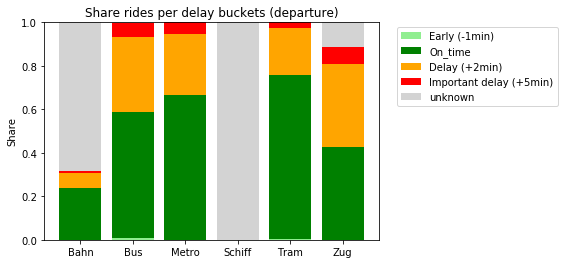

In [113]:
results = []
stacked = df_merged[~(df_merged['departure_delay_bucket'] == 'na')]
for t in df_merged['transport_mode'].unique():
    stacked_df = stacked[stacked['transport_mode'] == t]
    for d in stacked['departure_delay_bucket'].unique():
        x = stacked_df['ride_id'].count() # total transport_mode data
        y = stacked_df[stacked_df['departure_delay_bucket'] == d]['ride_id'].count() # total transport_mode, delay_type data
        results.append({
            'transport_mode':t,
            'delay_cat':d,
            'total':x,
            'total_delay':y,
            'delay_share': y / x
        })
df_all = pd.DataFrame(results).sort_values(by=['transport_mode','delay_cat'])[['transport_mode','delay_cat','total','total_delay','delay_share']]
df_early = df_all[df_all['delay_cat'] == 'early']
df_on_time = df_all[df_all['delay_cat'] == 'on_time']
df_delay = df_all[df_all['delay_cat'] == 'delay']
df_important_delay = df_all[df_all['delay_cat'] == 'important_delay']
df_unknown = df_all[df_all['delay_cat'] == 'unknown']

plt.bar(x=df_early['transport_mode'], height=df_early['delay_share'], color='lightgreen', label='Early (-1min)')
plt.bar(x=df_on_time['transport_mode'], height=df_on_time['delay_share'], color='green', bottom=df_early['delay_share'], label='On_time')
plt.bar(x=df_delay['transport_mode'], height=df_delay['delay_share'], color='orange', bottom=(df_early['delay_share'].values+df_on_time['delay_share'].values), label='Delay (+2min)')
plt.bar(x=df_important_delay['transport_mode'], height=df_important_delay['delay_share'], color='red', bottom=(df_early['delay_share'].values+df_on_time['delay_share'].values+df_delay['delay_share'].values), label='Important delay (+5min)')
plt.bar(x=df_unknown['transport_mode'], height=df_unknown['delay_share'], color='lightgrey', bottom=(df_early['delay_share'].values+df_on_time['delay_share'].values+df_delay['delay_share'].values+df_important_delay['delay_share'].values), label='unknown')
plt.title('Share rides per delay buckets (departure)')
plt.ylabel('Share')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

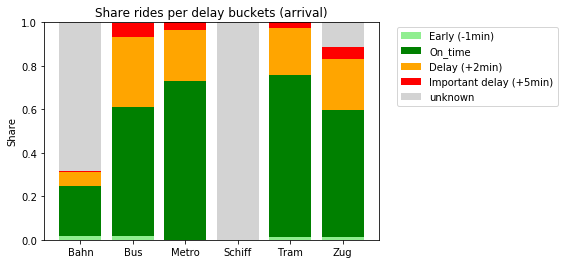

In [114]:
results = []
stacked = df_merged[~(df_merged['arrival_delay_bucket'] == 'na')]
for t in df_merged['transport_mode'].unique():
    stacked_df = stacked[stacked['transport_mode'] == t]
    for d in stacked['arrival_delay_bucket'].unique():
        x = stacked_df['ride_id'].count() # total transport_mode data
        y = stacked_df[stacked_df['arrival_delay_bucket'] == d]['ride_id'].count() # total transport_mode, delay_type data
        results.append({
            'transport_mode':t,
            'delay_cat':d,
            'total':x,
            'total_delay':y,
            'delay_share': y / x
        })
df_all = pd.DataFrame(results).sort_values(by=['transport_mode','delay_cat'])[['transport_mode','delay_cat','total','total_delay','delay_share']]
df_early = df_all[df_all['delay_cat'] == 'early']
df_on_time = df_all[df_all['delay_cat'] == 'on_time']
df_delay = df_all[df_all['delay_cat'] == 'delay']
df_important_delay = df_all[df_all['delay_cat'] == 'important_delay']
df_unknown = df_all[df_all['delay_cat'] == 'unknown']

plt.bar(x=df_early['transport_mode'], height=df_early['delay_share'], color='lightgreen', label='Early (-1min)')
plt.bar(x=df_on_time['transport_mode'], height=df_on_time['delay_share'], color='green', bottom=df_early['delay_share'], label='On_time')
plt.bar(x=df_delay['transport_mode'], height=df_delay['delay_share'], color='orange', bottom=(df_early['delay_share'].values+df_on_time['delay_share'].values), label='Delay (+2min)')
plt.bar(x=df_important_delay['transport_mode'], height=df_important_delay['delay_share'], color='red', bottom=(df_early['delay_share'].values+df_on_time['delay_share'].values+df_delay['delay_share'].values), label='Important delay (+5min)')
plt.bar(x=df_unknown['transport_mode'], height=df_unknown['delay_share'], color='lightgrey', bottom=(df_early['delay_share'].values+df_on_time['delay_share'].values+df_delay['delay_share'].values+df_important_delay['delay_share'].values), label='unknown')
plt.title('Share rides per delay buckets (arrival)')
plt.ylabel('Share')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

**Note:** 
<br> Interesting to note that rides (e.g.: trains) are **more frequently delayed at departure than at arrival**. Meaning in some cases they are **able to catch-up with the delay**. This seems to make "business sense". This means **when doing our predictions we will probably have to split in two models:**
* (a) departure delay perdiction 
* (b) arrival delay prediction

In [115]:
# plan to work with binary classifiers and therefore regroup target variables in binary classes (e.g.: 'no_delay','delay')
# 'na' won't be in scope
df_merged['arrival_delay_bucket_final'] = df_merged['arrival_delay_bucket'].replace({'early':'no_delay','on_time':'no_delay','unknown':'no_delay','important_delay':'delay'})
df_merged['departure_delay_bucket_final'] = df_merged['departure_delay_bucket'].replace({'early':'no_delay','on_time':'no_delay','unknown':'no_delay','important_delay':'delay'})
df_merged['arrival_important_delay_bucket_final'] = df_merged['arrival_delay_bucket'].replace({'early':'no_delay','on_time':'no_delay','unknown':'no_delay','delay':'no_delay'})
df_merged['departure_important_delay_bucket_final'] = df_merged['departure_delay_bucket'].replace({'early':'no_delay','on_time':'no_delay','unknown':'no_delay','delay':'no_delay'})

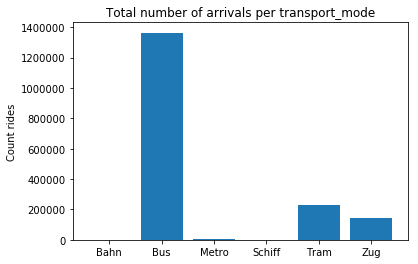

In [116]:
plt.bar(x='transport_mode', height='total', data=df_early)
plt.title('Total number of arrivals per transport_mode')
plt.ylabel('Count rides')
plt.show()

In [117]:
print('eta status')
df_merged['eta_status_clean'].value_counts(normalize=True)

eta status


PROGNOSE     0.633706
REAL         0.261837
NA           0.060287
ESTIMATED    0.031202
UNKOWN       0.012967
Name: eta_status_clean, dtype: float64

In [118]:
print('etd status')
df_merged['etd_status_clean'].value_counts(normalize=True)

etd status


PROGNOSE     0.630360
REAL         0.262282
NA           0.059444
ESTIMATED    0.034937
UNKOWN       0.012976
Name: etd_status_clean, dtype: float64

In [119]:
print('etd status per transport_mode')
df_merged.groupby('transport_mode')['etd_status_clean'].value_counts(normalize=True)
# will probably focus on trains as much higher share of real data

etd status per transport_mode


transport_mode  etd_status_clean
Bahn            UNKOWN              0.559188
                REAL                0.261556
                NA                  0.179256
Bus             PROGNOSE            0.640200
                REAL                0.254178
                NA                  0.058567
                ESTIMATED           0.044669
                UNKOWN              0.002387
Metro           PROGNOSE            0.931190
                NA                  0.068810
Schiff          UNKOWN              0.830065
                NA                  0.169935
Tram            PROGNOSE            0.955781
                NA                  0.044219
Zug             REAL                0.741420
                UNKOWN              0.122394
                NA                  0.088603
                PROGNOSE            0.047584
Name: etd_status_clean, dtype: float64

In [120]:
df_merged[(df_merged['transport_mode'] == 'Zug')].groupby('etd_status_clean')['departure_delay_bucket'].value_counts(normalize=True)

etd_status_clean  departure_delay_bucket
NA                na                        1.000000
PROGNOSE          on_time                   0.573099
                  delay                     0.353535
                  important_delay           0.072302
                  early                     0.001063
REAL              on_time                   0.485525
                  delay                     0.450151
                  important_delay           0.063932
                  early                     0.000392
UNKOWN            unknown                   0.830466
                  important_delay           0.169534
Name: departure_delay_bucket, dtype: float64

In [121]:
df_merged[(df_merged['transport_mode'] == 'Zug') & (df_merged['departure_delay_bucket'] == 'early')]['etd_status_clean'].value_counts()

REAL        46
PROGNOSE     8
Name: etd_status_clean, dtype: int64

In [122]:
df_merged_train = df_merged[df_merged['transport_mode'] == 'Zug']

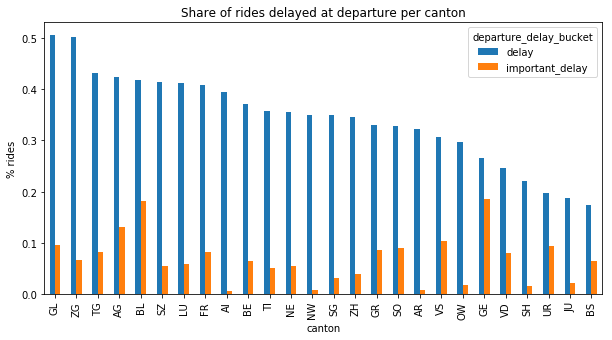

In [123]:
df_merged_train.groupby('canton')['departure_delay_bucket'].value_counts(normalize=True).to_frame().rename(columns={'departure_delay_bucket':'count'})\
.pivot_table(index='canton',columns='departure_delay_bucket', values='count').sort_values(by='delay', ascending=False)[['delay','important_delay']].plot(kind='bar', figsize=(10,5))
plt.title('Share of rides delayed at departure per canton')
plt.ylabel('% rides')
plt.show()

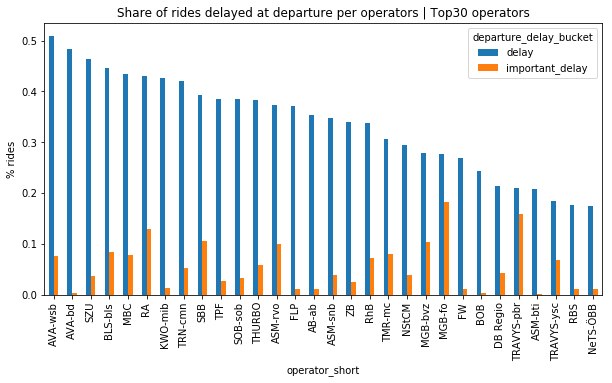

In [124]:
df_merged_train.groupby('operator_short')['departure_delay_bucket'].value_counts(normalize=True).to_frame().rename(columns={'departure_delay_bucket':'count'})\
.pivot_table(index='operator_short',columns='departure_delay_bucket', values='count').sort_values(by='delay', ascending=False)[['delay','important_delay']].head(30).plot(kind='bar', figsize=(10,5))
plt.title('Share of rides delayed at departure per operators | Top30 operators')
plt.ylabel('% rides')
plt.show()

**Comments:** <a name='share_delays'/> | <a href=#index>Back to top</a> | <a href=#eda>Back to EDA</a>
1. GL and ZG are both canonts with highest share of delays (~50%)
2. UR, VS, GE and GR have less frequent delays in comparison to other cantons but relatively high 'important delays'
3. Some operators are much less reliable with over 50% delays vs. others below 20%

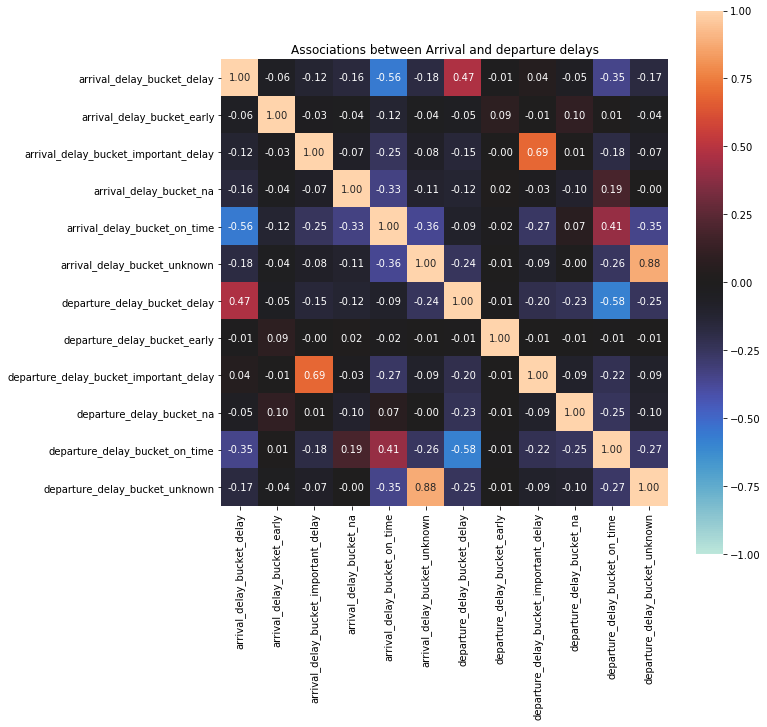

In [125]:
df_delay_associations = pd.get_dummies(df_merged_train[['arrival_delay_bucket','departure_delay_bucket']])
#pip install dython
from dython.nominal import associations # (https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9)
# Plot features associations
associations(df_delay_associations, theil_u=True, figsize=(10, 10), title='Associations between Arrival and departure delays')
plt.show()

**Comments: Arrival delay bucket X departure delay bucket**
1. Strong associations between 'important delay' arrival and 'important delay' departure (0.69)
2. Strong associations between 'delay' arrivals and 'delay' departure (0.47)
3. Strong negative associations between 'delay' arrivals and 'on time' departures (-0.35)

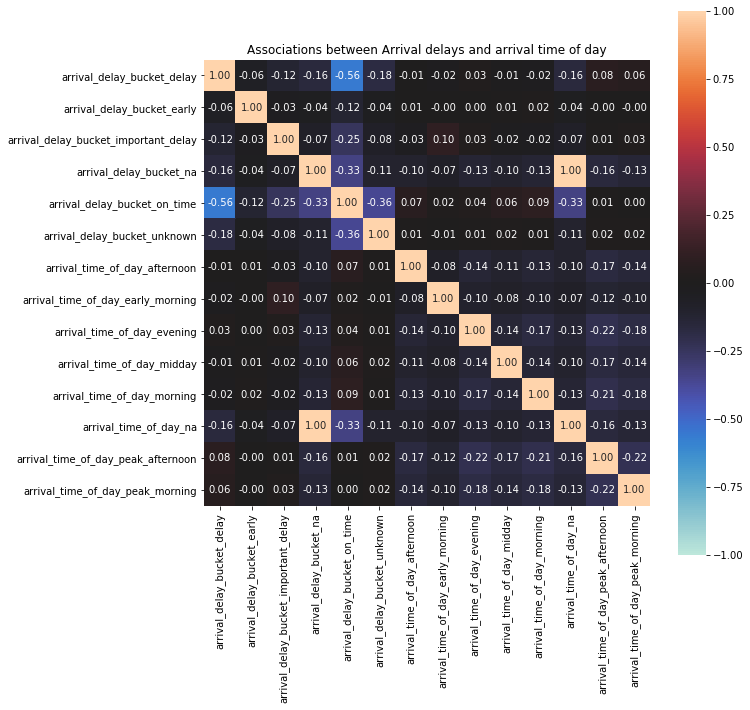

In [126]:
df_delay_associations = pd.get_dummies(df_merged_train[['arrival_delay_bucket','arrival_time_of_day']])
#pip install dython
from dython.nominal import associations # (https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9)
# Plot features associations
associations(df_delay_associations, theil_u=True, figsize=(10, 10), title='Associations between Arrival delays and arrival time of day')
plt.show()

**Comments: Arrival delay bucket X Arrival time of day** <a name='corr_time_of_day'/> | <a href=#index>Back to top</a> | <a href=#eda>Back to EDA</a>
1. Overall very low correlation
2. Highest meaningfull correlation is early_morning X important_delay at 0.10 => slightly more delays in the early morning 
3. On the other hand, on_time is more correlated for morning, midday and afternoons => outside of peak hours more chance for the train to be on time (makes business sense)

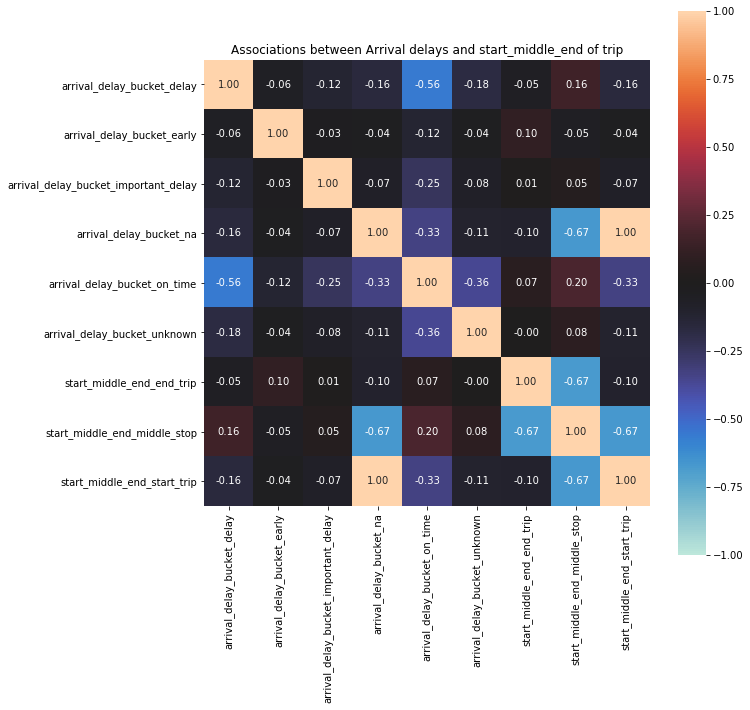

In [127]:
df_delay_associations = pd.get_dummies(df_merged_train[['arrival_delay_bucket','start_middle_end']])
#pip install dython
from dython.nominal import associations # (https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9)
# Plot features associations
associations(df_delay_associations,theil_u=True, figsize=(10, 10), title='Associations between Arrival delays and start_middle_end of trip')
plt.show()

**Comments: Arrival delay bucket X Start_middle_end of trip**
1. Overall low correlation
2. The two meaningfull rows to look at are 'start_middle_end_end_trip' and 'start_middle_end_middle_stop' as 'start_middle_end_start_trip' shall be empty for arrivals
3. 'Middle_stops' have more chances of having delay or important than final stop => reading is that train can probably catch-up with delay

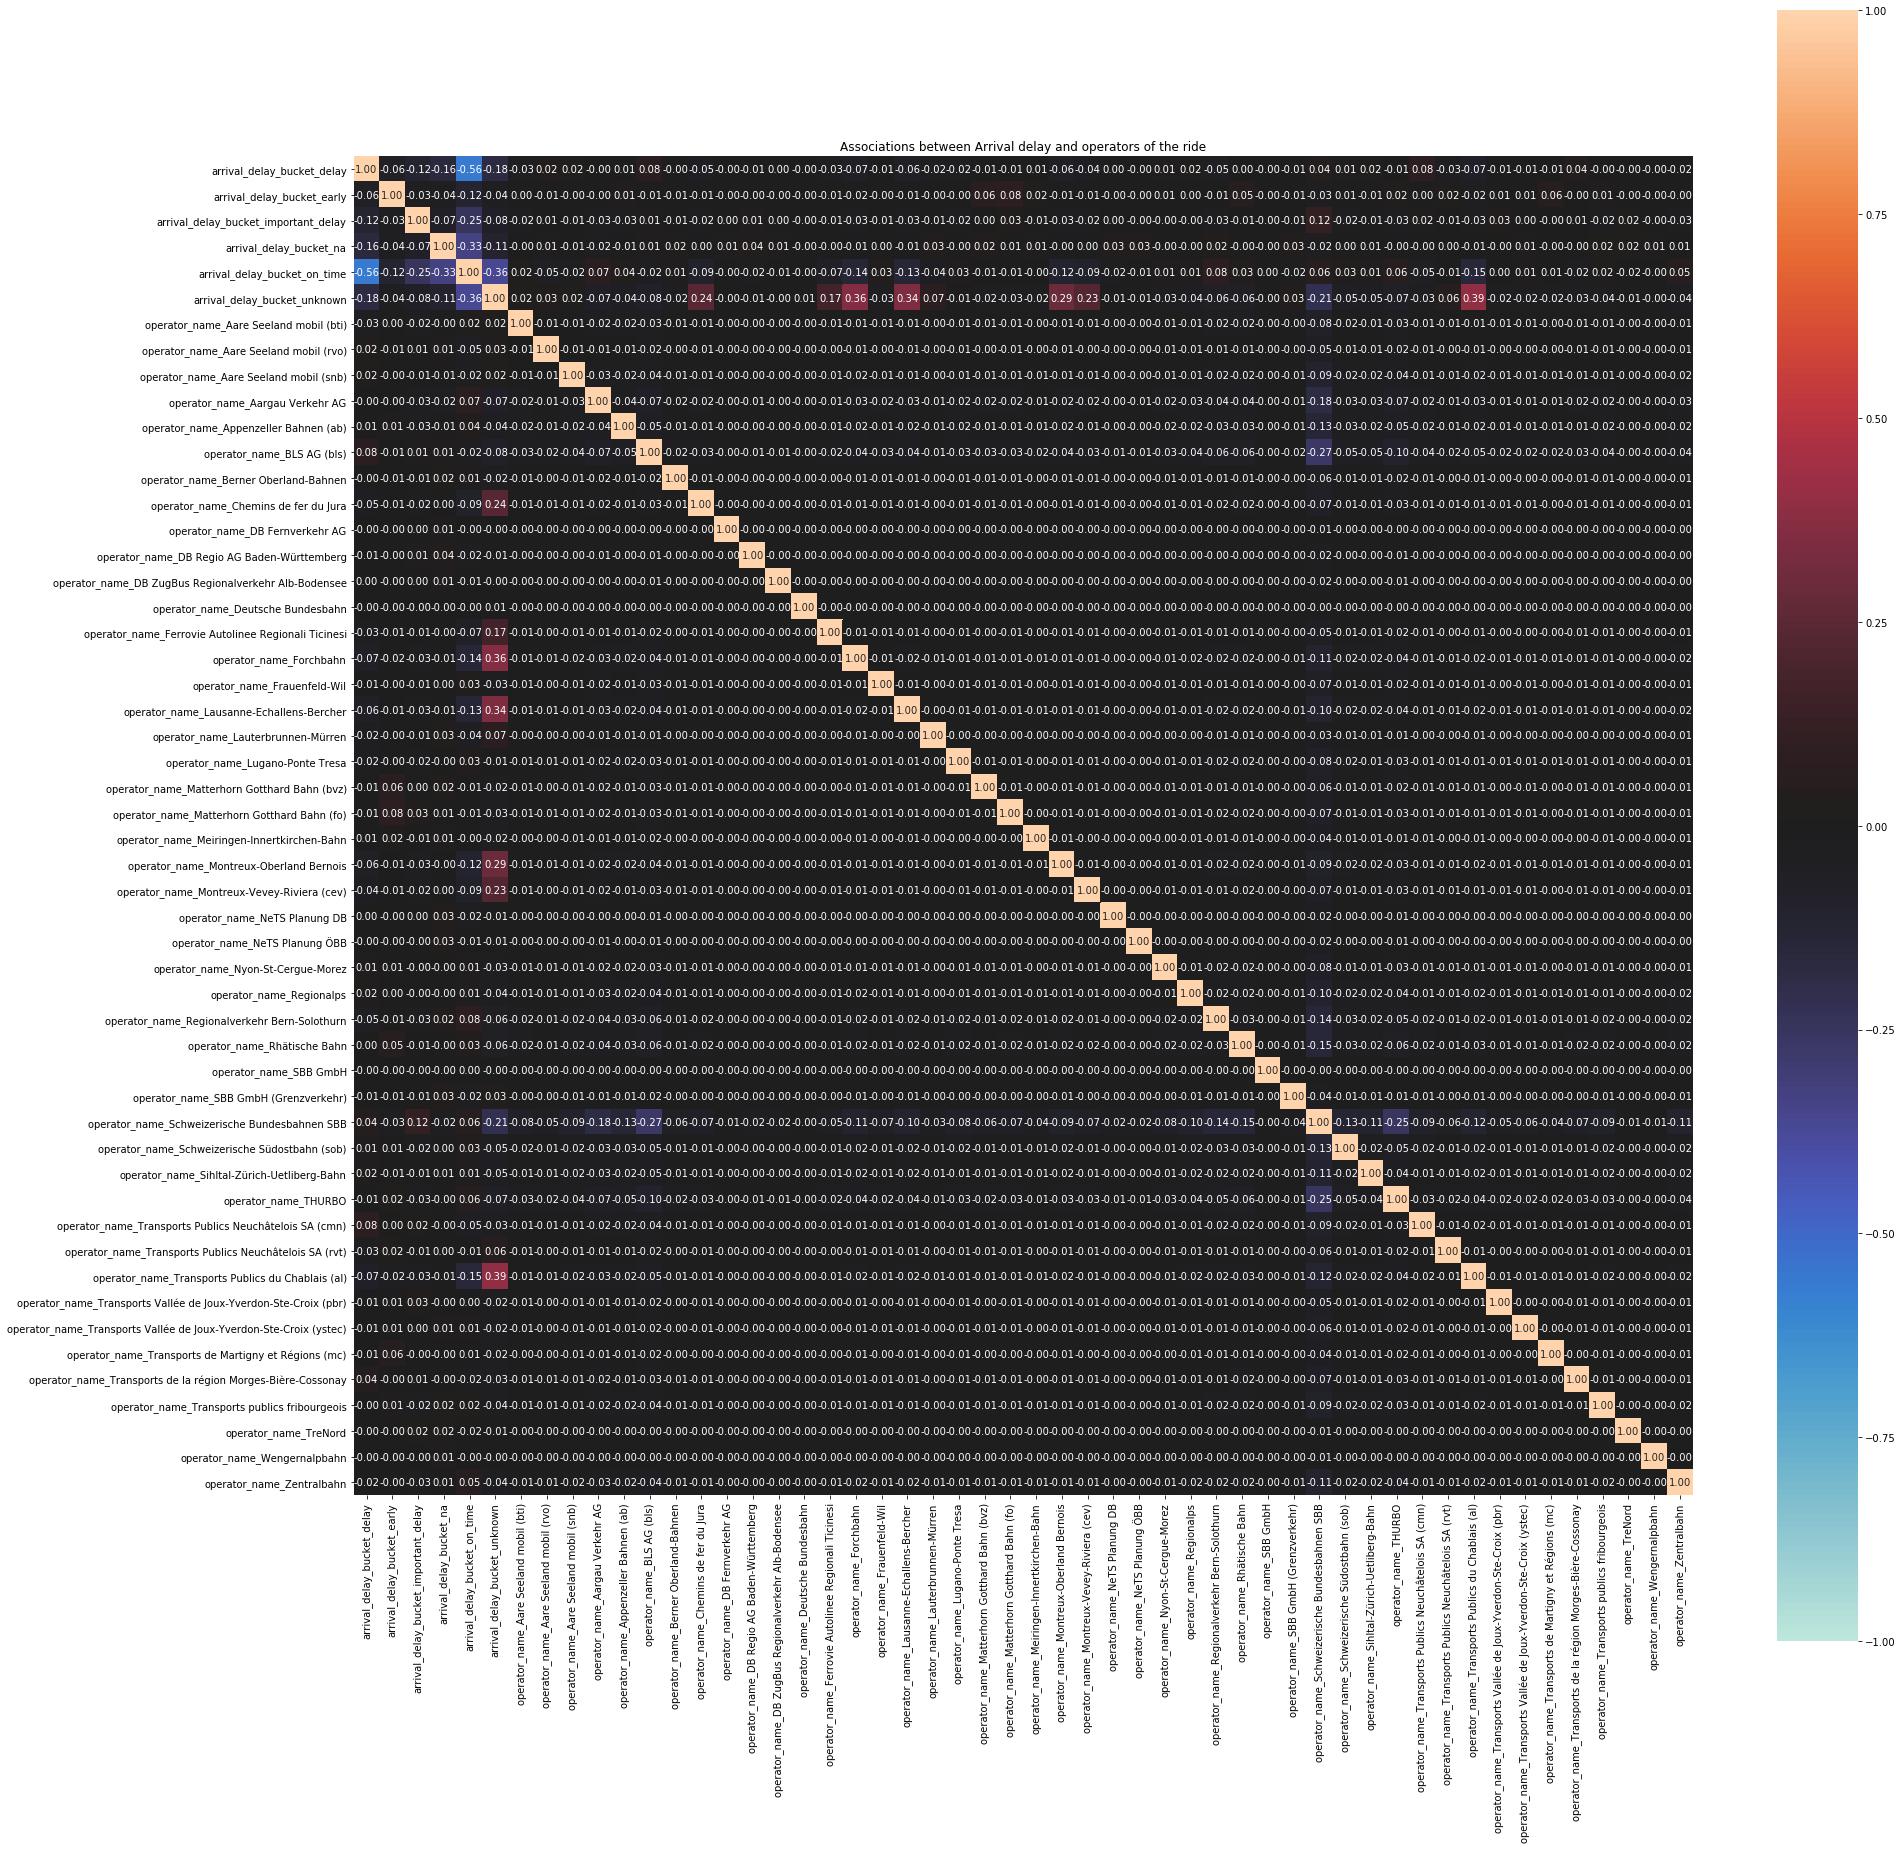

In [128]:
df_delay_associations = pd.get_dummies(df_merged_train[['arrival_delay_bucket','operator_name']])
#pip install dython
from dython.nominal import associations # (https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9)
# Plot features associations
associations(df_delay_associations, theil_u=True, figsize=(30, 30), title='Associations between Arrival delay and operators of the ride')
plt.show()

**Comments: Arrival delay bucket X Operator of the ride**
1. Overall very low correlation
2. Highest meaningfull correlation for 'on_time' is with 'Transports Public du Chablais' (-0.15)
3. There is no meaningfull correlation above |0.05| for 'delay' and 'important delay' which seems to indicate there is no clear patterns of delay or to low data points given the imbalanced classes

In [129]:
df_merged_stops_arr = df_merged_train.groupby(['transport_mode_stop','arrival_delay_bucket_final'])[['ride_id']].count()\
.pivot_table(index='transport_mode_stop', columns='arrival_delay_bucket_final', values='ride_id')
df_merged_stops_arr['ratio_delay'] = df_merged_stops_arr['delay'] / (df_merged_stops_arr['delay'] + df_merged_stops_arr['no_delay'])
df_merged_stops_arr.sort_values(by='no_delay', ascending=False)

arrival_delay_bucket_final,delay,na,no_delay,ratio_delay
transport_mode_stop,,,,
Zug,41417.0,13712.0,100801.0,0.291222
Zug_Bus,62.0,27.0,564.0,0.099042
Zug_Bus_Tram,NaN,82.0,410.0,NaN
Zug_Tram,7.0,38.0,195.0,0.034653
Zug_Kabinenbahn,12.0,42.0,93.0,0.114286
Zug_Metro,NaN,71.0,71.0,NaN
Unbekannt,21.0,4.0,59.0,0.262500
Zahnradbahn,NaN,1.0,4.0,NaN


In [130]:
df_merged_stops_dep = df_merged_train.groupby(['transport_mode_stop','departure_delay_bucket_final'])[['ride_id']].count()\
.pivot_table(index='transport_mode_stop', columns='departure_delay_bucket_final', values='ride_id')
df_merged_stops_dep['ratio_delay'] = df_merged_stops_dep['delay'] / (df_merged_stops_dep['delay'] + df_merged_stops_dep['no_delay'])
df_merged_stops_dep.sort_values(by='no_delay', ascending=False)

departure_delay_bucket_final,delay,na,no_delay,ratio_delay
transport_mode_stop,,,,
Zug,66412.0,13718.0,75800.0,0.466993
Zug_Bus,135.0,27.0,491.0,0.215655
Zug_Bus_Tram,NaN,82.0,410.0,NaN
Zug_Tram,2.0,38.0,200.0,0.009901
Zug_Kabinenbahn,12.0,41.0,94.0,0.113208
Zug_Metro,NaN,71.0,71.0,NaN
Unbekannt,26.0,3.0,55.0,0.320988
Zahnradbahn,NaN,4.0,1.0,NaN


**Outliers** <a name='outliers'/> | <a href=#index>Back to top</a> | <a href=#eda>Back to EDA</a>
* z-scores *(departure_delay_min & arrival_delay_min)*

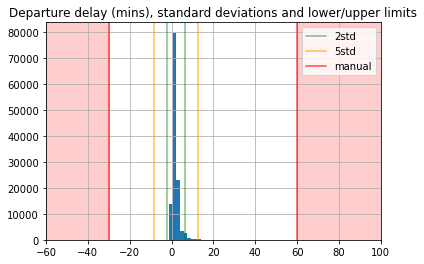

In [131]:
df_merged_train['departure_delay_min'].hist(bins=100)
plt.axvline(x=df_merged_train['departure_delay_min'].mean() + 2*df_merged_train['departure_delay_min'].std(), color='green', alpha=0.5,label='2std')
plt.axvline(x=df_merged_train['departure_delay_min'].mean() - 2*df_merged_train['departure_delay_min'].std(), color='green', alpha=0.5)
plt.axvline(x=df_merged_train['departure_delay_min'].mean() + 5*df_merged_train['departure_delay_min'].std(), color='orange', alpha=0.7,label='5std')
plt.axvline(x=df_merged_train['departure_delay_min'].mean() - 5*df_merged_train['departure_delay_min'].std(), color='orange', alpha=0.7)
plt.axvline(x=60, color='red', alpha=0.7,label='manual')
plt.axvline(x=-30, color='red', alpha=0.7)
plt.axvspan(xmin=60, xmax=100, color='red', alpha=0.2)
plt.axvspan(xmin=-60, xmax=-30, color='red', alpha=0.2)
plt.xlim((-60,100))
plt.legend()
plt.title('Departure delay (mins), standard deviations and lower/upper limits')
plt.show()

In [132]:
print('Departure delay (mins) - stats')
df_merged_train['departure_delay_min'].describe()

Departure delay (mins) - stats


count    124758.000000
mean          1.972387
std           2.102349
min         -49.000000
25%           1.000000
50%           2.000000
75%           2.000000
max         122.000000
Name: departure_delay_min, dtype: float64

In [133]:
idx = ((df_merged_train['departure_delay_min'] > 60) | (df_merged_train['departure_delay_min'] < -30))
print('count outliers:',idx.sum())

count outliers: 8


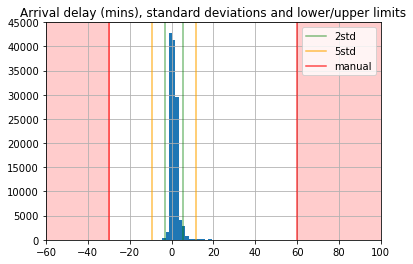

In [134]:
df_merged_train['arrival_delay_min'].hist(bins=100)
plt.axvline(x=df_merged_train['arrival_delay_min'].mean() + 2*df_merged_train['arrival_delay_min'].std(), color='green', alpha=0.5,label='2std')
plt.axvline(x=df_merged_train['arrival_delay_min'].mean() - 2*df_merged_train['arrival_delay_min'].std(), color='green', alpha=0.5)
plt.axvline(x=df_merged_train['arrival_delay_min'].mean() + 5*df_merged_train['arrival_delay_min'].std(), color='orange', alpha=0.7,label='5std')
plt.axvline(x=df_merged_train['arrival_delay_min'].mean() - 5*df_merged_train['arrival_delay_min'].std(), color='orange', alpha=0.7)
plt.axvline(x=60, color='red', alpha=0.7,label='manual')
plt.axvline(x=-30, color='red', alpha=0.7)
plt.axvspan(xmin=60, xmax=100, color='red', alpha=0.2)
plt.axvspan(xmin=-60, xmax=-30, color='red', alpha=0.2)
plt.xlim((-60,100))
plt.legend()
plt.title('Arrival delay (mins), standard deviations and lower/upper limits')
plt.show()

In [135]:
print('Arrival delay (mins) - stats')
df_merged_train['arrival_delay_min'].describe()

Arrival delay (mins) - stats


count    124691.000000
mean          1.190471
std           2.137326
min         -44.000000
25%          -0.000000
50%           1.000000
75%           2.000000
max         114.000000
Name: arrival_delay_min, dtype: float64

In [136]:
idx = ((df_merged_train['arrival_delay_min'] > 60) | (df_merged_train['arrival_delay_min'] < -30)) | idx
print('total outliers:',idx.sum())

total outliers: 12


**Comments on outliers**
1. Decide to consider as outliers for 'departure_delay_min' and 'arrival_delay_min' data points above 60min and below 30min
2. Outliers will have low impact on model as planning to build classifiers prediction if delay or not. Therefore not difference if delays of 3mins or 33mins

In [137]:
# create outlier column in df after full outliers analysis
df_merged_train['outliers'] = idx

C:\Users\glaurent\AppData\Local\Continuum\anaconda3\envs\exts-ml\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


**Splitting in two data sets using start_middle_end column** ('arrival_set' and 'departure_set' as will need to be predicated separately)
* 'end trip' means there is no departure to forecast
* 'start trip' means there is no arrival to forecast
* 'middle' means there is both arrival and departure to forecast

In [138]:
df_merged_train['start_middle_end'].value_counts(normalize=True)

middle_stop    0.822832
end_trip       0.088603
start_trip     0.088565
Name: start_middle_end, dtype: float64

In [139]:
df_merged_train[df_merged_train['start_middle_end'] == 'start_trip']['arrival_time'].value_counts()

Series([], Name: arrival_time, dtype: int64)

In [140]:
df_merged_train[df_merged_train['start_middle_end'] == 'end_trip']['departure_time'].value_counts()

Series([], Name: departure_time, dtype: int64)

In [141]:
# 'departure_set'
print('Null values for "departure_time"',df_merged_train[~(df_merged_train['start_middle_end'] == 'end_trip')]['departure_time'].isnull().sum())
df_merged_train_dep = df_merged_train[~(df_merged_train['start_middle_end'] == 'end_trip')]
# columns related to arrival will be removed when working with final sets (train, validation, test)
# = > exclude: arrival_time, eta, eta_status_clean, arrival_time_of_day, arrival_delay_min, arrival_delay_bucket, arrival_delay_bucket_final, arrival_important_delay_bucket_final

Null values for "departure_time" 0


In [142]:
# 'arrival_set'
print('Null values for "departure_time"',df_merged_train[~(df_merged_train['start_middle_end'] == 'start_trip')]['arrival_time'].isnull().sum())
df_merged_train_arr = df_merged_train[~(df_merged_train['start_middle_end'] == 'start_trip')]
# columns related to arrival will be removed when working with final sets (train, validation, test)
# = > exclude: departure_time, dta, dta_status_clean, departure_time_of_day, departure_delay_min, departure_delay_bucket, departure_delay_bucket_final, departure_important_delay_bucket_final

Null values for "departure_time" 0


**Saving data** *(to avoid having to re-do cleaning each time)* <a name='saving_data'/> | <a href=#index>Back to top</a>

In [143]:
# Save them into a .npz file
np.savez('capstone_sbb.npz'
         ,df_merged_train=df_merged_train
         ,df_merged_train_columns=df_merged_train.columns
         
         ,df_merged_train_dep=df_merged_train_dep
         ,df_merged_train_dep_columns=df_merged_train_dep.columns
         ,df_merged_train_arr=df_merged_train_arr
         ,df_merged_train_arr_columns=df_merged_train_arr.columns
         
         ,df_merged=df_merged
         ,df_merged_columns=df_merged.columns
         ,df_clean_final=df_clean_final
         ,df_clean_final_columns=df_clean_final.columns
         ,df_stops_clean=df_stops_clean
         ,df_stops_clean_columns=df_stops_clean.columns
        )

In [144]:
# Load the npz file
with np.load('capstone_sbb.npz', allow_pickle=False) as npz_file:
    # It's a dictionary-like object
    print(list(npz_file.keys()))

['df_merged_train', 'df_merged_train_columns', 'df_merged_train_dep', 'df_merged_train_dep_columns', 'df_merged_train_arr', 'df_merged_train_arr_columns', 'df_merged', 'df_merged_columns', 'df_clean_final', 'df_clean_final_columns', 'df_stops_clean', 'df_stops_clean_columns']


In [145]:
import numpy as np
with np.load('capstone_sbb.npz', allow_pickle=True) as npz_file:
    # Load the arrays
    df_merged_train_x = npz_file['df_merged_train']
    df_merged_train_columns_x = npz_file['df_merged_train_columns']
    
    df_merged_train_dep_x = npz_file['df_merged_train_dep']
    df_merged_train_dep_columns_x = npz_file['df_merged_train_dep_columns']
    df_merged_train_arr_x = npz_file['df_merged_train_arr']
    df_merged_train_arr_columns_x = npz_file['df_merged_train_arr_columns']
    
    df_merged_x = npz_file['df_merged']
    df_merged_columns_x = npz_file['df_merged_columns']
    df_clean_final_x = npz_file['df_clean_final']
    df_clean_final_columns_x = npz_file['df_clean_final_columns']
    df_stops_clean_x = npz_file['df_stops_clean']
    df_stops_clean_columns_x = npz_file['df_stops_clean_columns']


print('df_merged_final:', df_merged_train_x.shape)
print('df_merged_final_columns:', df_merged_train_columns_x.shape)
print('df_merged_final_departure:', df_merged_train_dep_x.shape)
print('df_merged_final_departure_columns:', df_merged_train_dep_columns_x.shape)
print('df_merged_final_arrival:', df_merged_train_arr_x.shape)
print('df_merged_final_arrival_columns:', df_merged_train_arr_columns_x.shape)
print('df_merged:', df_merged_x.shape)
print('df_merged_columns:', df_merged_columns_x.shape)
print('df_clean_final:', df_clean_final_x.shape)
print('df_clean_final_columns:', df_clean_final_columns_x.shape)
print('df_stops_clean:', df_stops_clean_x.shape)
print('df_stops_clean_columns:', df_stops_clean_columns_x.shape)

df_merged_final: (158121, 39)
df_merged_final_columns: (39,)
df_merged_final_departure: (144111, 39)
df_merged_final_departure_columns: (39,)
df_merged_final_arrival: (144117, 39)
df_merged_final_arrival_columns: (39,)
df_merged: (1854124, 38)
df_merged_columns: (38,)
df_clean_final: (1854124, 27)
df_clean_final_columns: (27,)
df_stops_clean: (27738, 10)
df_stops_clean_columns: (10,)


In [146]:
# import pandas as pd
# df_merged_train = pd.DataFrame(df_merged_train_x, columns=df_merged_train_columns_x)